In [ ]:
# ============================================================================
# ANÁLISIS ESTADÍSTICO DE ETFs: VALIDACIÓN DE HIPÓTESIS DE INVERSIÓN
# ============================================================================


import warnings
warnings.filterwarnings('ignore')

# Librerías Core
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from tqdm import tqdm
from datetime import datetime

# Librerías Estadísticas
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
#from statsmodels.stats.diagnostic import het_arch
#from arch import arch_model

# Librerías ML
from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Librerías Optimización de Portafolio
from pypfopt import (EfficientFrontier, expected_returns, risk_models, objective_functions, plotting, HRPOpt)

# Configuración de almacenamiento
import os
import sqlite3

# ============================================================================
# FASE 1: DEFINICIÓN DEL PROBLEMA
# ============================================================================

"""
CONTEXTO DE NEGOCIO:
-------------------
Los ETFs se han popularizado como vehículos de inversión por su bajo costo,
liquidez y diversificación. Sin embargo, surgen preguntas críticas:

1. ¿Realmente ofrecen mejor perfil riesgo-retorno que instrumentos tradicionales?
2. ¿Una cartera optimizada de ETFs supera estrategias pasivas?
3. ¿Existe redundancia/colinealidad que diluya los beneficios de diversificación?

HIPÓTESIS A VALIDAR:
-------------------
H1: RENDIMIENTO AJUSTADO AL RIESGO
    Pregunta: ¿Los ETFs de renta variable son una mejor oportunidad que bonos?
    Métrica: Sharpe Ratio
    Validación: Test t de diferencia de medias
    
H2: EFICIENCIA DE CARTERAS OPTIMIZADAS
    Pregunta: ¿Una cartera Markowitz con ETFs supera la clásica 60/40?
    Métrica: Sharpe Ratio de carteras
    Validación: Comparación directa + Bootstrap CI
    
H3: RIESGO DE SOBREDIVERSIFICACIÓN
    Pregunta: ¿Existe redundancia entre ETFs que reduce beneficios reales?
    Métricas: 
        - % de pares con correlación > 0.9
        - Número de componentes PCA que explican 80% varianza
    Validación: Análisis de correlaciones + PCA

DECISIONES QUE SE TOMARÁN:
--------------------------
- Selección de ETFs para portafolio óptimo
- Estrategia de asignación (Markowitz vs HRP vs Pasiva)
- Identificación de ETFs redundantes a eliminar
"""

'\nCONTEXTO DE NEGOCIO:\n-------------------\nLos ETFs se han popularizado como vehículos de inversión por su bajo costo,\nliquidez y diversificación. Sin embargo, surgen preguntas críticas:\n\n1. ¿Realmente ofrecen mejor perfil riesgo-retorno que instrumentos tradicionales?\n2. ¿Una cartera optimizada de ETFs supera estrategias pasivas?\n3. ¿Existe redundancia/colinealidad que diluya los beneficios de diversificación?\n\nHIPÓTESIS A VALIDAR:\n-------------------\nH1: RENDIMIENTO AJUSTADO AL RIESGO\n    Pregunta: ¿Los ETFs de renta variable son una mejor oportunidad que bonos?\n    Métrica: Sharpe Ratio\n    Validación: Test t de diferencia de medias\n    \nH2: EFICIENCIA DE CARTERAS OPTIMIZADAS\n    Pregunta: ¿Una cartera Markowitz con ETFs supera la clásica 60/40?\n    Métrica: Sharpe Ratio de carteras\n    Validación: Comparación directa + Bootstrap CI\n    \nH3: RIESGO DE SOBREDIVERSIFICACIÓN\n    Pregunta: ¿Existe redundancia entre ETFs que reduce beneficios reales?\n    Métricas:

In [2]:
# ============================================================================
# FASE 2: PREPARACIÓN DE DATOS (ETL)
# ============================================================================

"""
ARQUITECTURA DE DATOS:
---------------------
¿Por qué SQLite + CSV?
- SQLite: Persistencia estructurada, queries SQL, escalabilidad
- CSV: Portabilidad, respaldo, análisis externo (Excel, R)

¿Por qué esta selección de ETFs?
- 100+ ETFs cubriendo: mercado amplio, sectores, países, bonos, commodities
- Representatividad: cada asset class relevante
- Liquidez: solo ETFs con volumen significativo
"""

# ---------------------------
# 2.1) DEFINICIÓN DEL UNIVERSO DE INVERSIÓN
# ---------------------------

TICKERS = [
    # === RENTA VARIABLE US - MERCADO AMPLIO (7) ===
    # Razón: Capturar beta del mercado estadounidense
    "SPY", "IVV", "VOO",  # S&P 500 (tres emisores diferentes)
    "VTI", "SCHB", "ITOT", "SPLG",  # Total Market
    
    # === RENTA VARIABLE US - SECTORES GICS (11) ===
    # Razón: Exposición sectorial para tilts tácticos
    "XLK",  # Technology
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLF",  # Financials
    "XLV",  # Healthcare
    "XLI",  # Industrials
    "XLB",  # Materials
    "XLU",  # Utilities
    "XLC",  # Communications
    
    # === RENTA VARIABLE US - SIZE/STYLE (18) ===
    # Razón: Factor premiums (size, value, growth)
    "QQQ",  # Nasdaq-100 (tech-heavy)
    "IWM", "VB",  # Small Cap
    "DIA",  # Dow Jones
    "MDY", "IJH", "VO",  # Mid Cap
    "IJR", "VBR",  # Small Value
    "VOT", "VBK",  # Small Growth
    "VOE",  # Mid Value
    "VUG", "IWF", "MGK",  # Large Growth
    "VTV", "IWD", "MGV",  # Large Value
    "IWN",  # Small Value
    
    # === RENTA VARIABLE INTERNACIONAL - DESARROLLADOS (4) ===
    # Razón: Diversificación geográfica, reducir home bias
    "VEA", "IEFA", "EFA", "VEU",
    
    # === RENTA VARIABLE - EMERGENTES (3) ===
    # Razón: Mayor potencial de crecimiento, mayor volatilidad
    "EEM", "VWO", "FXI",
    
    # === RENTA VARIABLE - PAÍSES ESPECÍFICOS (17) ===
    # Razón: Exposición directa a economías específicas
    "EWT",  # Taiwan
    "EWH",  # Hong Kong
    "EWG",  # Germany
    "EWJ",  # Japan
    "EWL",  # Switzerland
    "EWP",  # Spain
    "EWQ",  # France
    "EWZ",  # Brazil
    "EWY",  # South Korea
    "EWA",  # Australia
    "EWU",  # UK
    "EWN",  # Netherlands
    "EWC",  # Canada
    "EWK",  # Belgium
    "INDA",  # India
    "EPOL",  # Poland
    "ARGT",  # Argentina
    
    # === RENTA VARIABLE - GLOBAL (5) ===
    # Razón: One-stop shop para exposición global
    "VT", "VXUS", "ACWI", "ACWX", "VSS",
    
    # === RENTA FIJA (10) ===
    # Razón: Estabilidad, descorrelación con equity, income
    "TLT",  # Long-term Treasury (>20 años)
    "IEF",  # Mid-term Treasury (7-10 años)
    "AGG",  # Aggregate Bond (investment grade)
    "LQD",  # Investment Grade Corporate
    "HYG",  # High Yield Corporate
    "BND",  # Total Bond Market
    "TIP",  # TIPS (protección inflación)
    "SHV",  # Short-term Treasury (<1 año)
    "SHY",  # 1-3 Year Treasury
    "MUB",  # Municipal Bonds
    
    # === COMMODITIES (5) ===
    # Razón: Hedge contra inflación, diversificación
    "GDX",  # Gold Miners
    "GLD",  # Gold
    "SLV",  # Silver
    "DBC",  # Commodities Basket
    "USO",  # Oil
    
    # === REAL ESTATE (1) ===
    # Razón: Income, diversificación, inflación hedge
    "VNQ",
    
    # === DIVIDENDOS (9) ===
    # Razón: Income, lower volatility, quality tilt
    "SCHD", "VIG", "SDY", "VYM", "DVY", "HDV", "DLN", "FVD", "NOBL",
    
    # === FACTOR/SMART BETA (5) ===
    # Razón: Capturar factor premiums sistemáticamente
    "USMV",  # Low Volatility
    "QUAL",  # Quality
    "MTUM",  # Momentum
    "VLUE",  # Value
    "RSP",   # Equal Weight S&P 500
    
    # === INCOME/COVERED CALL (3) ===
    # Razón: High yield mediante opciones cubiertas
    "JEPI", "QYLD", "XYLD",
    
    # === TEMÁTICOS/SECTORES ESPECÍFICOS (7) ===
    # Razón: Exposición a tendencias seculares
    "XBI",   # Biotech
    "SMH",   # Semiconductors
    "SOXX",  # Semiconductors
    "IGV",   # Software
    "KWEB",  # China Internet
    "ASHR",  # China A-Shares
    "TAN",   # Solar Energy
    
    # === ARK INVEST (5) ===
    # Razón: Disruptive innovation exposure
    "ARKK", "ARKQ", "ARKW", "ARKG", "ARKF"
]

In [3]:
# ---------------------------
# 2.2) DESCARGA Y PERSISTENCIA DE DATOS
# ---------------------------

"""
ARQUITECTURA DE DESCARGA:
------------------------
¿Por qué no descargar siempre desde Yahoo Finance?
1. Rate limits de la API
2. Velocidad: SQLite es 10-100x más rápido
3. Reproducibilidad: mismos datos para múltiples ejecuciones
4. Offline capability

ESTRATEGIA DE CACHING:
1. Check SQLite DB
2. Si no existe, check CSV
3. Si no existe, descargar de Yahoo Finance
4. Guardar en ambos formatos

MANEJO DE DATOS FALTANTES:
- Threshold: 80% de datos válidos (eliminar ETFs con >20% missing)
- Imputación: 
    * Forward fill (ffill): usa último valor válido
    * Backward fill (bfill): para NAs al inicio de la serie
- Justificación: Los precios ajustados raramente tienen gaps, 
  pero ETFs nuevos tienen historiales cortos
"""

# Configuración
DATA_PATH = "etf_prices.csv"
DB_PATH = "etf_data.db"
start = "2016-01-01"  # 9 años de datos (incluye crisis COVID)
end = datetime.today().strftime('%Y-%m-%d')

def download_adjclose(tickers, start, end):
    """
    Descarga precios ajustados con caching inteligente.
    
    Flujo:
    1. Intenta cargar desde CSV (más rápido)
    2. Si falta, descarga de Yahoo Finance
    3. Limpia datos (elimina ETFs con <80% datos)
    4. Imputa NAs (ffill + bfill)
    5. Persiste en CSV + SQLite
    
    Returns:
    -------
    pd.DataFrame: Precios ajustados con índice datetime
    """
    
    # Paso 1: Intentar cargar desde cache CSV
    if os.path.exists(DATA_PATH):
        print("📁 Cargando datos desde cache local (CSV)...")
        data = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
        if len(set(tickers) - set(data.columns)) == 0:
            print(f"✅ Cache hit: {len(data.columns)} ETFs, {len(data)} días")
            return data.loc[start:end]
    
    # Paso 2: Descargar desde Yahoo Finance
    print("🌐 Descargando datos desde Yahoo Finance...")
    data = yf.download(
        tickers, 
        start=start, 
        end=end, 
        progress=True,  # Mostrar barra de progreso
        threads=True,    # Descarga paralela
        multi_level_index=False, 
        auto_adjust=False
    )['Adj Close']
    
    # Paso 3: Normalizar estructura
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    data = data.sort_index()
    
    # Paso 4: Limpieza de calidad de datos
    initial_etfs = len(data.columns)
    data = data.dropna(axis=1, thresh=int(0.8 * len(data)))
    removed_etfs = initial_etfs - len(data.columns)
    
    if removed_etfs > 0:
        print(f"⚠️  Eliminados {removed_etfs} ETFs por datos insuficientes (<80% válidos)")
    
    # Paso 5: Imputación de valores faltantes
    # Forward fill: propaga último valor válido hacia adelante
    # Backward fill: propaga primer valor válido hacia atrás (para inicio de serie)
    data = data.fillna(method='ffill').fillna(method='bfill')
    
    # Paso 6: Persistencia dual
    print("💾 Guardando datos localmente...")
    data.to_csv(DATA_PATH)
    
    conn = sqlite3.connect(DB_PATH)
    data.to_sql("etf_prices", conn, if_exists="replace", index=True)
    conn.close()
    
    print(f"✅ Descarga completa: {len(data.columns)} ETFs, {len(data)} días")
    return data

# Ejecutar descarga
prices = download_adjclose(TICKERS, start, end)

print(f"""
📊 RESUMEN DE DATOS:
   ETFs: {len(prices.columns)}
   Período: {prices.index.min().date()} → {prices.index.max().date()}
   Días: {len(prices)}
   Missing: {prices.isna().sum().sum()}
""")


🌐 Descargando datos desde Yahoo Finance...


[*********************100%***********************]  110 of 110 completed


⚠️  Eliminados 3 ETFs por datos insuficientes (<80% válidos)
💾 Guardando datos localmente...
✅ Descarga completa: 107 ETFs, 2514 días

📊 RESUMEN DE DATOS:
   ETFs: 107
   Período: 2016-01-04 → 2025-12-31
   Días: 2514
   Missing: 0



In [20]:
# ---------------------------
# 2.3) TRANSFORMACIÓN: CÁLCULO DE RETORNOS
# ---------------------------

"""
¿RETORNOS SIMPLES O LOGARÍTMICOS?
---------------------------------
Retornos Simples: r_t = (P_t - P_{t-1}) / P_{t-1}
  ✓ Intuitivos (10% es 10%)
  ✓ Agregables cross-sectionally (portfolio returns)
  ✗ NO agregables en el tiempo (r_total ≠ Σr_t)

Retornos Logarítmicos: r_t = ln(P_t / P_{t-1})
  ✓ Agregables en el tiempo (r_total = Σr_t)
  ✓ Simétricos: ln(1.1) ≈ -ln(0.91)
  ✓ Mejores propiedades estadísticas (normalidad)
  ✗ NO agregables cross-sectionally

DECISIÓN: Usamos ambos
- Retornos simples: Para optimización de portafolio (agregación cross-sectional)
- Retornos log: Para análisis estadístico (normalidad, simetría)
"""

rets = prices.pct_change().dropna()  # Retornos simples
logrets = np.log(prices).diff().dropna()  # Retornos logarítmicos

print(f"✅ Retornos calculados: {len(rets)} observaciones por ETF")


✅ Retornos calculados: 2513 observaciones por ETF


In [21]:
# ============================================================================
# FASE 3: EXPLORACIÓN DE ENFOQUES - ESTADÍSTICA DESCRIPTIVA
# ============================================================================

"""
¿POR QUÉ ESTADÍSTICA DESCRIPTIVA?
---------------------------------
Antes de validar hipótesis, necesitamos entender:
1. Distribución de retornos (normalidad, colas pesadas)
2. Perfil riesgo-retorno de cada ETF
3. Presencia de outliers o anomalías

MÉTRICAS:
--------------
1. Retorno Anualizado: μ × 252 (assuming 252 trading days)
2. Volatilidad Anualizada: σ × √252 (volatilidad escala con √tiempo)
3. Sharpe Ratio: (μ - r_f) / σ (retorno por unidad de riesgo)
4. Skewness: Asimetría (crashes más frecuentes que rallies?)
5. Kurtosis: Colas pesadas (eventos extremos más frecuentes?)
6. VaR 95%: Pérdida máxima esperada 5% de los días
7. CVaR 95%: Pérdida promedio cuando se excede VaR (tail risk)
8. Downside Vol: Volatilidad solo de retornos negativos (para Sortino)
"""

# ---------------------------
# 3.1) ESTADÍSTICAS UNIVARIADAS
# ---------------------------

def summary_stats(returns, trading_days=252, rf_rate=0.04):
    """
    Calcula estadísticas descriptivas comprehensivas.
    
    Parameters:
    ----------
    returns : pd.DataFrame
        Retornos diarios (simples)
    trading_days : int
        Días de trading por año (252 en US)
    rf_rate : float
        Tasa libre de riesgo anual (4% default)
    
    Returns:
    -------
    pd.DataFrame: Estadísticas por ETF
    """
    
    # Retornos anualizados
    ann_return = returns.mean() * trading_days
    
    # Volatilidad anualizada
    ann_vol = returns.std() * np.sqrt(trading_days)
    
    # Sharpe Ratio (sin ajuste por RF)
    sharpe_naive = ann_return / ann_vol
    
    # Sharpe Ratio (ajustado por RF)
    sharpe_rf = (ann_return - rf_rate) / ann_vol
    
    # Momentos de la distribución
    skew = returns.skew()  # Asimetría
    kurt = returns.kurtosis()  # Exceso de curtosis
    
    # Riesgo de cola izquierda
    var_95 = returns.quantile(0.05)  # VaR histórico 95%
    cvar_95 = returns[returns <= var_95].mean()  # CVaR/ES
    
    # Downside risk (para Sortino Ratio)
    downside_vol = returns[returns < 0].std() * np.sqrt(trading_days)
    
    return pd.DataFrame({
        'Ann_Return': ann_return,
        'Ann_Vol': ann_vol,
        'Sharpe_Naive': sharpe_naive,
        'Sharpe_RF_Adj': sharpe_rf,
        'Skewness': skew,
        'Kurtosis': kurt,
        'VaR_95': var_95,
        'CVaR_95': cvar_95,
        'Downside_Vol': downside_vol
    })

# Calcular estadísticas
stats_df = summary_stats(rets, rf_rate=0.04)
stats_df = stats_df.round(4)

# Mostrar top 20 por Sharpe Ratio
print("🏆 TOP 20 ETFs POR SHARPE RATIO (RF-ADJUSTED):")
display(stats_df.sort_values('Sharpe_RF_Adj', ascending=False).head(20))

# Persistir resultados
stats_df.to_csv("etf_summary_stats.csv")

conn = sqlite3.connect(DB_PATH)
stats_df.to_sql("etf_stats", conn, if_exists="replace", index=True)
conn.close()

print("💾 Estadísticas guardadas en CSV y SQLite")



🏆 TOP 20 ETFs POR SHARPE RATIO (RF-ADJUSTED):


,Ann_Return,Ann_Vol,Sharpe_Naive,Sharpe_RF_Adj,Skewness,Kurtosis,VaR_95,CVaR_95,Downside_Vol
Ticker,,,,,,,,,
SMH,0.3232,0.3209,1.0072,0.8825,-0.0699,5.2819,-0.0314,-0.0468,0.2336
XLK,0.2332,0.2424,0.9619,0.7969,-0.0508,9.7008,-0.0243,-0.0359,0.1884
SOXX,0.2966,0.3272,0.9065,0.7842,-0.0192,6.0270,-0.0328,-0.0477,0.2385
QQQ,0.2053,0.2234,0.9187,0.7397,-0.1991,7.7456,-0.0229,-0.0339,0.1762
GLD,0.1462,0.1480,0.9879,0.7177,-0.2056,3.4409,-0.0148,-0.0211,0.1047
IWF,0.1890,0.2092,0.9034,0.7121,-0.1881,9.8719,-0.0208,-0.0320,0.1687
MGK,0.1946,0.2181,0.8921,0.7088,-0.1588,9.9958,-0.0218,-0.0332,0.1755
VUG,0.1860,0.2139,0.8695,0.6825,-0.2384,9.8863,-0.0212,-0.0326,0.1725
ARKQ,0.2310,0.2942,0.7850,0.6491,-0.0652,3.2210,-0.0313,-0.0418,0.2051


💾 Estadísticas guardadas en CSV y SQLite


<Figure size 1600x800 with 0 Axes>

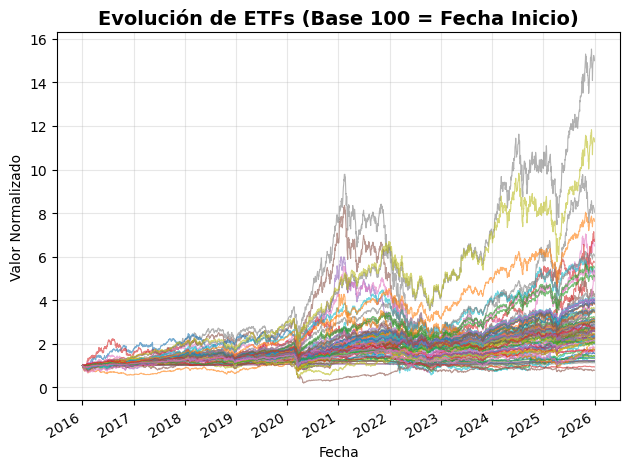

💡 Interpretación: ETFs que terminan arriba → mejores retornos acumulados
   Dispersión vertical → heterogeneidad de performance


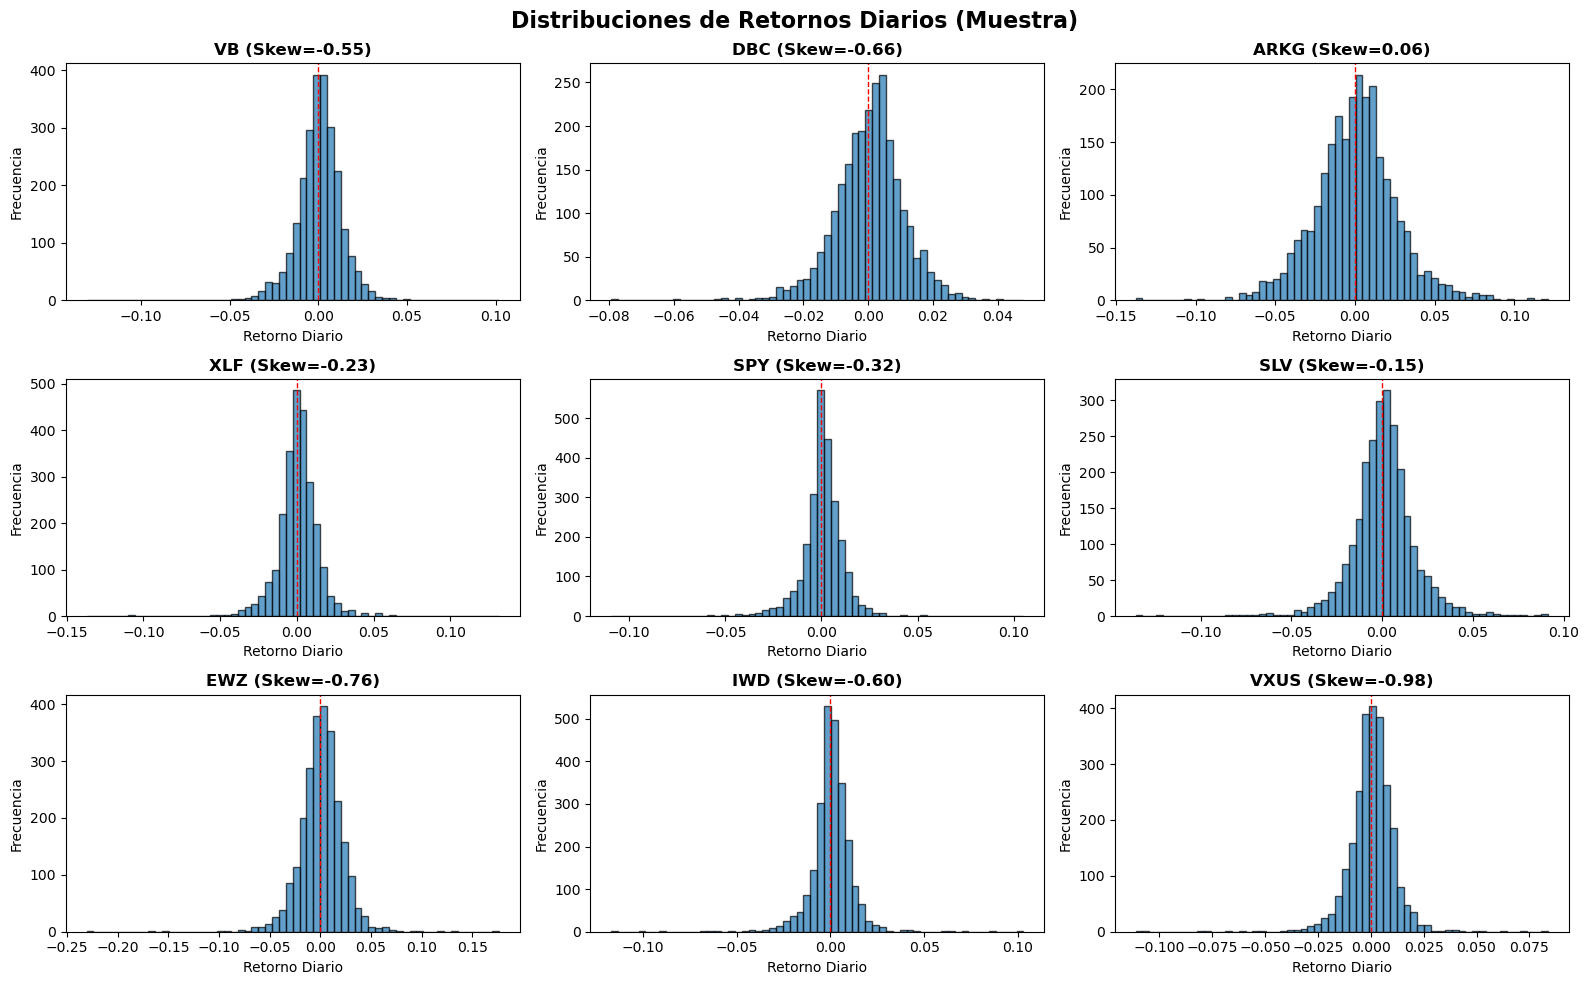

💡 Interpretación: Colas pesadas (valores extremos) → No-normalidad
   Asimetría negativa (skew < 0) → Más crashes que rallies


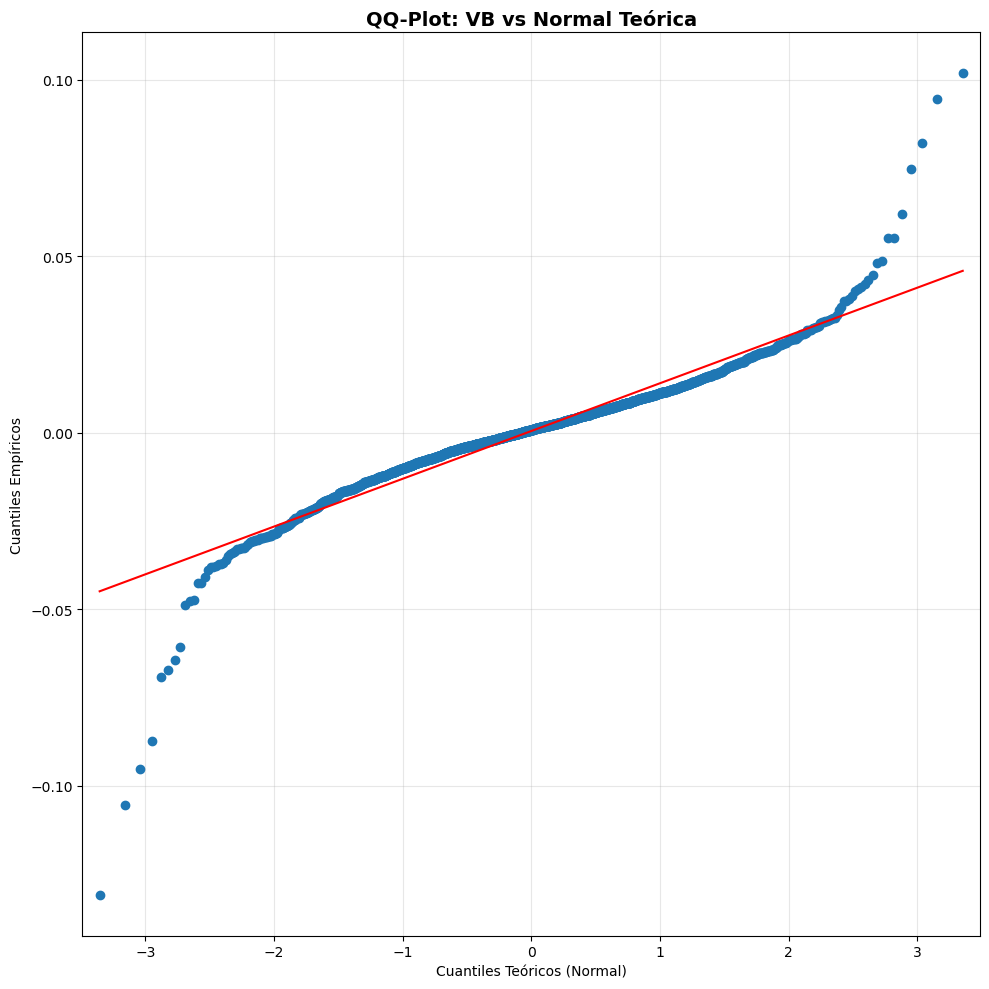

💡 Interpretación: Desviaciones en colas → retornos NO normales
   Implicación: VaR paramétrico (asume normalidad) subestimará riesgo


In [22]:
# ---------------------------
# 3.2) ANÁLISIS VISUAL - EXPLORATORY DATA ANALYSIS
# ---------------------------

"""
VISUALIZACIONES CLAVE:
---------------------
1. Series Temporales Normalizadas: Ver co-movimientos, divergencias
2. Histogramas de Retornos: Verificar normalidad, identificar outliers
3. QQ-Plots: Test visual de normalidad vs distribución teórica
"""

# === 3.2.1) SERIES NORMALIZADAS ===
plt.figure(figsize=(16, 8))
normalized = prices / prices.iloc[0]
normalized.plot(legend=False, alpha=0.6, linewidth=0.8)
plt.title("Evolución de ETFs (Base 100 = Fecha Inicio)", fontsize=14, fontweight='bold')
plt.ylabel("Valor Normalizado")
plt.xlabel("Fecha")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("01_normalized_prices.png", dpi=150)
plt.show()

print("💡 Interpretación: ETFs que terminan arriba → mejores retornos acumulados")
print("   Dispersión vertical → heterogeneidad de performance")

# === 3.2.2) DISTRIBUCIÓN DE RETORNOS ===
example_etfs = rets.sample(axis=1, n=9, random_state=42).columns
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(example_etfs):
    axes[i].hist(rets[col].dropna(), bins=60, alpha=0.7, edgecolor='black')
    axes[i].set_title(f"{col} (Skew={rets[col].skew():.2f})", fontweight='bold')
    axes[i].axvline(0, color='red', linestyle='--', linewidth=1)
    axes[i].set_xlabel("Retorno Diario")
    axes[i].set_ylabel("Frecuencia")

plt.suptitle("Distribuciones de Retornos Diarios (Muestra)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("02_returns_distributions.png", dpi=150)
plt.show()

print("💡 Interpretación: Colas pesadas (valores extremos) → No-normalidad")
print("   Asimetría negativa (skew < 0) → Más crashes que rallies")

# === 3.2.3) QQ-PLOT (Normalidad Test Visual) ===
"""
QQ-Plot: Quantile-Quantile Plot
-------------------------------
Compara cuantiles empíricos vs teóricos de distribución normal.

Si puntos están en línea recta → distribución normal
Desviaciones en colas → colas más pesadas que normal
Curvas en S → asimetría
"""

plt.figure(figsize=(10, 10))
sm.qqplot(rets[example_etfs[0]].dropna(), line='s', ax=plt.gca())
plt.title(f"QQ-Plot: {example_etfs[0]} vs Normal Teórica", 
          fontsize=14, fontweight='bold')
plt.xlabel("Cuantiles Teóricos (Normal)")
plt.ylabel("Cuantiles Empíricos")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("03_qq_plot.png", dpi=150)
plt.show()

print("💡 Interpretación: Desviaciones en colas → retornos NO normales")
print("   Implicación: VaR paramétrico (asume normalidad) subestimará riesgo")



In [24]:
# ---------------------------
# 3.3) TEST FORMAL DE NORMALIDAD
# ---------------------------

"""
TESTS ESTADÍSTICOS DE NORMALIDAD
---------------------------------
Jarque-Bera: H0 = distribución normal
ARCH-LM: H0 = homocedasticidad (varianza constante)

Estos tests formalizan lo que el QQ-plot muestra visualmente.
"""

print("\n" + "="*80)
print("TESTS FORMALES DE NORMALIDAD")
print("="*80)

# Test Jarque-Bera en muestra de ETFs
jb_results = []

for etf in example_etfs[:5]:  # Primeros 5 ETFs de la muestra
    jb_stat, jb_pval = stats.jarque_bera(rets[etf].dropna())
    
    jb_results.append({
        'ETF': etf,
        'JB_Statistic': jb_stat,
        'p_value': jb_pval,
        'Normal': jb_pval > 0.05
    })

jb_df = pd.DataFrame(jb_results)

print("\n📊 RESULTADOS JARQUE-BERA (H0: Normalidad):")
display(jb_df)

n_normal = jb_df['Normal'].sum()
print(f"""
✅ INTERPRETACIÓN:
   ETFs con distribución normal (p>0.05): {n_normal}/{len(jb_df)}
   ETFs con colas pesadas (p<0.05): {len(jb_df)-n_normal}/{len(jb_df)}
   
💡 Conclusión: {'Mayoría NO normal' if n_normal < len(jb_df)/2 else 'Varios son normales'}
   → {'Usar VaR histórico en lugar de paramétrico' if n_normal < len(jb_df)/2 else 'VaR paramétrico puede ser razonable'}
""")


TESTS FORMALES DE NORMALIDAD

📊 RESULTADOS JARQUE-BERA (H0: Normalidad):


,ETF,JB_Statistic,p_value,Normal
0,VB,12008.680711,0.000000e+00,False
1,DBC,2028.766773,0.000000e+00,False
2,ARKG,272.885306,5.542537e-60,False
3,XLF,23070.374126,0.000000e+00,False
4,SPY,22673.414341,0.000000e+00,False



✅ INTERPRETACIÓN:
   ETFs con distribución normal (p>0.05): 0/5
   ETFs con colas pesadas (p<0.05): 5/5
   
💡 Conclusión: Mayoría NO normal
   → Usar VaR histórico en lugar de paramétrico




H3 PARTE 1: ANÁLISIS DE CORRELACIONES Y REDUNDANCIA


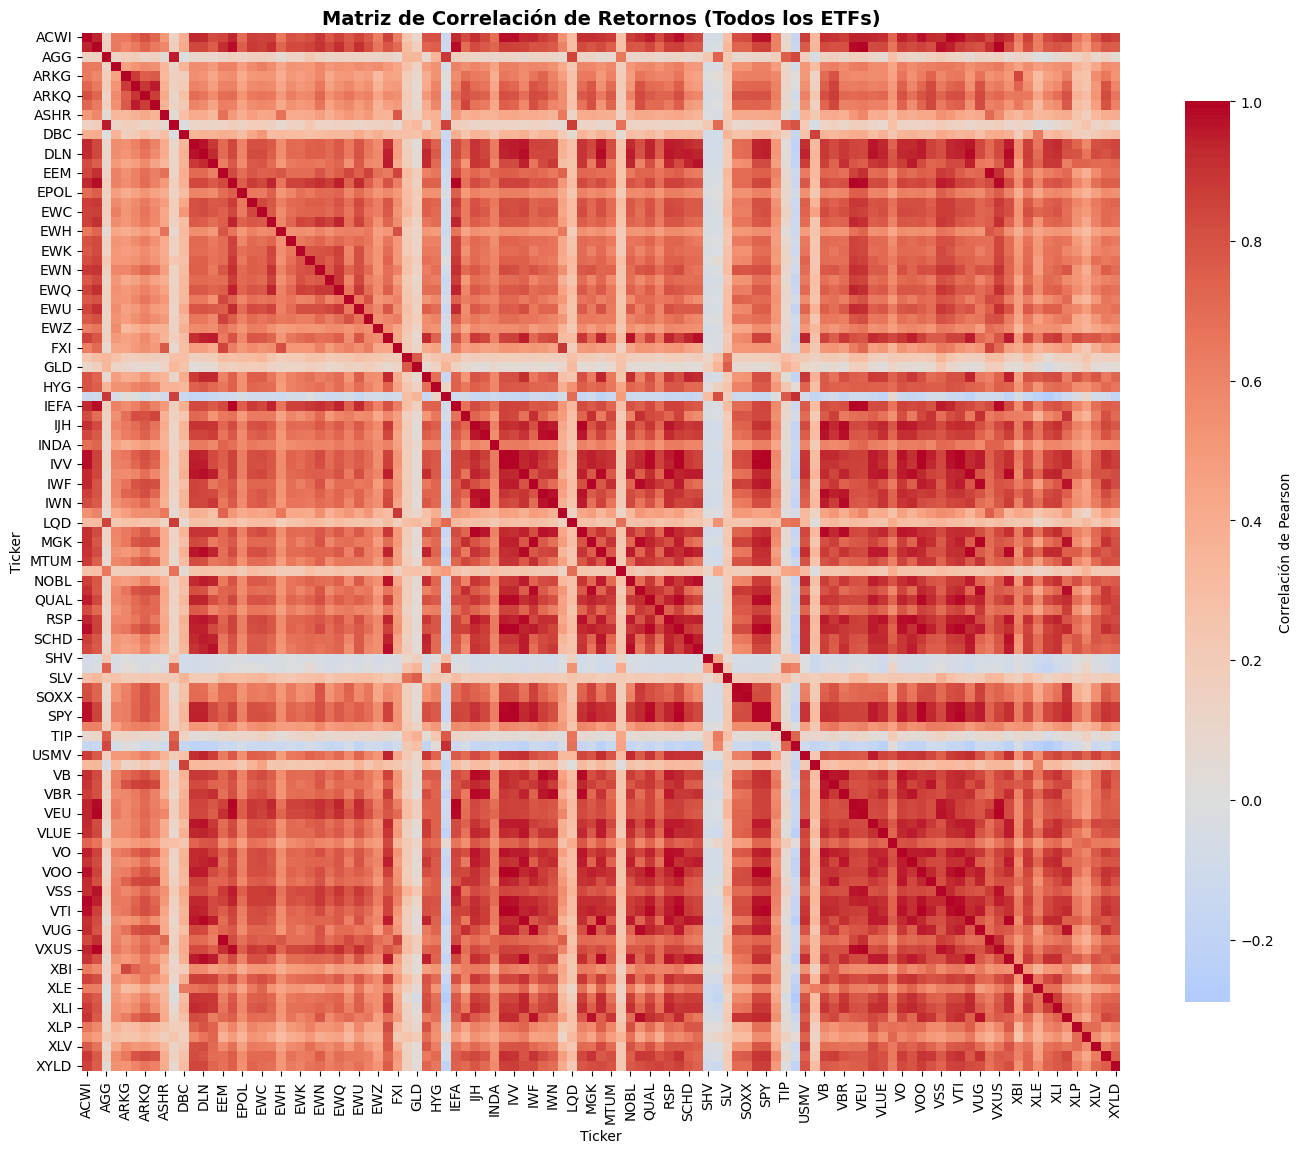


📊 RESULTADOS:
   Total de pares posibles: 5671
   Pares con corr > 0.9: 568
   Porcentaje: 10.02%
   Umbral hipótesis: 30%
   
✅ HIPÓTESIS H3 (Parte 1): RECHAZADA
   ✓ Redundancia aceptable


📋 EJEMPLOS DE PARES CON ALTA CORRELACIÓN:


,ETF1,ETF2,Correlation
253,IVV,VOO,0.999455
183,IJH,MDY,0.999153
247,IVV,SPY,0.998887
467,SPY,VOO,0.998788
430,SCHB,VTI,0.998658
231,ITOT,VTI,0.998607
219,ITOT,SCHB,0.998357
124,EFA,IEFA,0.997949
505,VEU,VXUS,0.997746
42,ACWX,VEU,0.997286


In [25]:
# ============================================================================
# FASE 4: IMPLEMENTACIÓN - VALIDACIÓN DE HIPÓTESIS
# ============================================================================

# ---------------------------
# H3 - PARTE 1: ANÁLISIS DE CORRELACIONES
# ---------------------------

"""
HIPÓTESIS H3 (Parte 1):
----------------------
"Existe riesgo de sobrediversificación si >30% de pares tienen correlación >0.9"

¿POR QUÉ IMPORTA?
- ETFs con corr >0.9 son funcionalmente idénticos
- Incluir ambos en portafolio NO agrega diversificación
- Ejemplo: SPY, IVV, VOO (todos S&P 500) → corr ≈ 0.999

METODOLOGÍA:
1. Calcular matriz de correlación (retornos)
2. Contar pares con corr > 0.9
3. Comparar vs umbral 30%

IMPLICACIONES:
- Si validada → muchos ETFs redundantes
- Solución: Clustering para identificar representantes
"""

print("\n" + "="*80)
print("H3 PARTE 1: ANÁLISIS DE CORRELACIONES Y REDUNDANCIA")
print("="*80)

# Calcular matriz de correlación
corr = rets.corr()

# Visualizar heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', center=0, 
            annot=False, fmt=".2f", square=True, 
            cbar_kws={"shrink": 0.8, "label": "Correlación de Pearson"})
plt.title("Matriz de Correlación de Retornos (Todos los ETFs)", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("04_correlation_matrix.png", dpi=150)
plt.show()

# Identificar pares con alta correlación
high_corr_pairs = []
cols = corr.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if corr.iloc[i, j] > 0.9:
            high_corr_pairs.append((cols[i], cols[j], corr.iloc[i, j]))

# Calcular porcentaje
total_pairs = len(cols) * (len(cols) - 1) / 2
pct_high_corr = len(high_corr_pairs) / total_pairs

print(f"""
📊 RESULTADOS:
   Total de pares posibles: {int(total_pairs)}
   Pares con corr > 0.9: {len(high_corr_pairs)}
   Porcentaje: {pct_high_corr:.2%}
   Umbral hipótesis: 30%
   
✅ HIPÓTESIS H3 (Parte 1): {'VALIDADA' if pct_high_corr > 0.30 else 'RECHAZADA'}
   {'⚠️  ALTA redundancia entre ETFs' if pct_high_corr > 0.30 else '✓ Redundancia aceptable'}
""")

# Guardar pares
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['ETF1', 'ETF2', 'Correlation'])
high_corr_df.to_csv("etf_high_correlation_pairs.csv", index=False)

conn = sqlite3.connect(DB_PATH)
high_corr_df.to_sql("high_corr_pairs", conn, if_exists="replace", index=False)
conn.close()

# Mostrar ejemplos
print("\n📋 EJEMPLOS DE PARES CON ALTA CORRELACIÓN:")
display(high_corr_df.sort_values('Correlation', ascending=False).head(10))




H3 PARTE 2: ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

📊 RESULTADOS PCA:
   Varianza explicada por PC1: 61.64%
   Varianza explicada por PC1-3: 73.87%
   Componentes para 80% varianza: 5
   Componentes para 90% varianza: 11
   
✅ HIPÓTESIS H3 (Parte 2): VALIDADA
   ⚠️  ALTA concentración sistémica



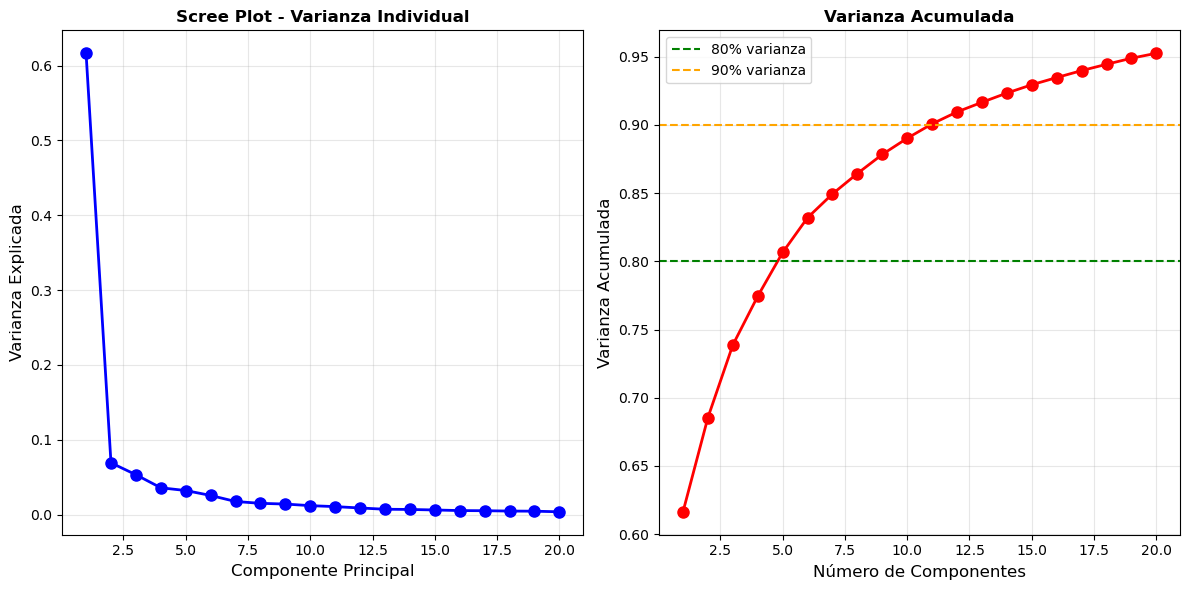


📋 LOADINGS DE LOS PRIMEROS 3 COMPONENTES (Top 10 ETFs por magnitud):

PC1 - Explica 61.64% de varianza:
  ARKK: +0.180
  ARKW: +0.166
  ARKG: +0.166
  SOXX: +0.155
  SMH: +0.150
  TAN: +0.145
  ARKQ: +0.142
  KWEB: +0.130
  XBI: +0.129
  EWZ: +0.124

PC2 - Explica 6.91% de varianza:
  ARKK: +0.347
  ARKG: +0.328
  ARKW: +0.315
  KWEB: +0.239
  XLE: -0.234
  USO: -0.227
  XBI: +0.180
  ARKQ: +0.170
  EWZ: -0.150
  IGV: +0.138

PC3 - Explica 5.32% de varianza:
  GDX: +0.398
  KWEB: +0.365
  FXI: +0.277
  SLV: +0.276
  ASHR: +0.215
  USO: +0.181
  EWZ: +0.174
  EEM: +0.155
  VWO: +0.151
  GLD: +0.151


In [26]:
# ---------------------------
# H3 - PARTE 2: ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
# ---------------------------

"""
HIPÓTESIS H3 (Parte 2):
----------------------
"Existe concentración de riesgo sistémico si 3-5 componentes explican >80% varianza"

¿QUÉ ES PCA?
------------
PCA encuentra "factores ocultos" que explican varianza de retornos.

Interpretación:
- PC1 (típicamente): "Factor Mercado" (β del CAPM)
- PC2: Puede ser "Value vs Growth", "Size", etc.
- PC3+: Factores más específicos

¿POR QUÉ IMPORTA?
- Si 3 PCs explican 80% → todos ETFs se mueven por mismos drivers
- Implicación: Diversificación ilusoria (riesgo sistémico domina)
- Si 20+ PCs necesarios → verdadera diversificación

METODOLOGÍA:
1. Estandarizar retornos (PCA sensible a escala)
2. Calcular componentes principales
3. Analizar varianza explicada acumulada
4. Examinar loadings (contribución de cada ETF a cada PC)
"""

print("\n" + "="*80)
print("H3 PARTE 2: ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
print("="*80)

# Configuración PCA
n_comp = min(20, rets.shape[1])  # Calcular hasta 20 PCs

# Preparar datos (imputar NAs con 0 - asumir retorno neutral)
X = rets.fillna(0).values

# Ajustar PCA
pca = PCA(n_components=n_comp)
pca.fit(X)

# Varianza explicada
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# Encontrar número de PCs para 80% varianza
n_pcs_80 = np.argmax(cum_explained >= 0.80) + 1

print(f"""
📊 RESULTADOS PCA:
   Varianza explicada por PC1: {explained[0]:.2%}
   Varianza explicada por PC1-3: {cum_explained[2]:.2%}
   Componentes para 80% varianza: {n_pcs_80}
   Componentes para 90% varianza: {np.argmax(cum_explained >= 0.90) + 1}
   
✅ HIPÓTESIS H3 (Parte 2): {'VALIDADA' if n_pcs_80 <= 5 else 'RECHAZADA'}
   {'⚠️  ALTA concentración sistémica' if n_pcs_80 <= 5 else '✓ Buena diversificación factorial'}
""")

# Scree plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained)+1), explained, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Componente Principal', fontsize=12)
plt.ylabel('Varianza Explicada', fontsize=12)
plt.title('Scree Plot - Varianza Individual', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cum_explained)+1), cum_explained, 'ro-', linewidth=2, markersize=8)
plt.axhline(0.80, color='green', linestyle='--', label='80% varianza')
plt.axhline(0.90, color='orange', linestyle='--', label='90% varianza')
plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada', fontsize=12)
plt.title('Varianza Acumulada', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("05_pca_variance_explained.png", dpi=150)
plt.show()

# Loadings (pesos de ETFs en cada PC)
loadings = pd.DataFrame(
    pca.components_.T, 
    index=rets.columns, 
    columns=[f'PC{i+1}' for i in range(len(explained))]
)

print("\n📋 LOADINGS DE LOS PRIMEROS 3 COMPONENTES (Top 10 ETFs por magnitud):")
for i in range(3):
    pc = f'PC{i+1}'
    top_loadings = loadings[pc].abs().sort_values(ascending=False).head(10)
    print(f"\n{pc} - Explica {explained[i]:.2%} de varianza:")
    for etf, loading in top_loadings.items():
        print(f"  {etf}: {loadings.loc[etf, pc]:+.3f}")

# Guardar loadings
loadings.to_csv("etf_pca_loadings.csv")

conn = sqlite3.connect(DB_PATH)
loadings.to_sql("pca_loadings", conn, if_exists="replace", index=True)
conn.close()



CLUSTERING JERÁRQUICO - IDENTIFICACIÓN DE GRUPOS


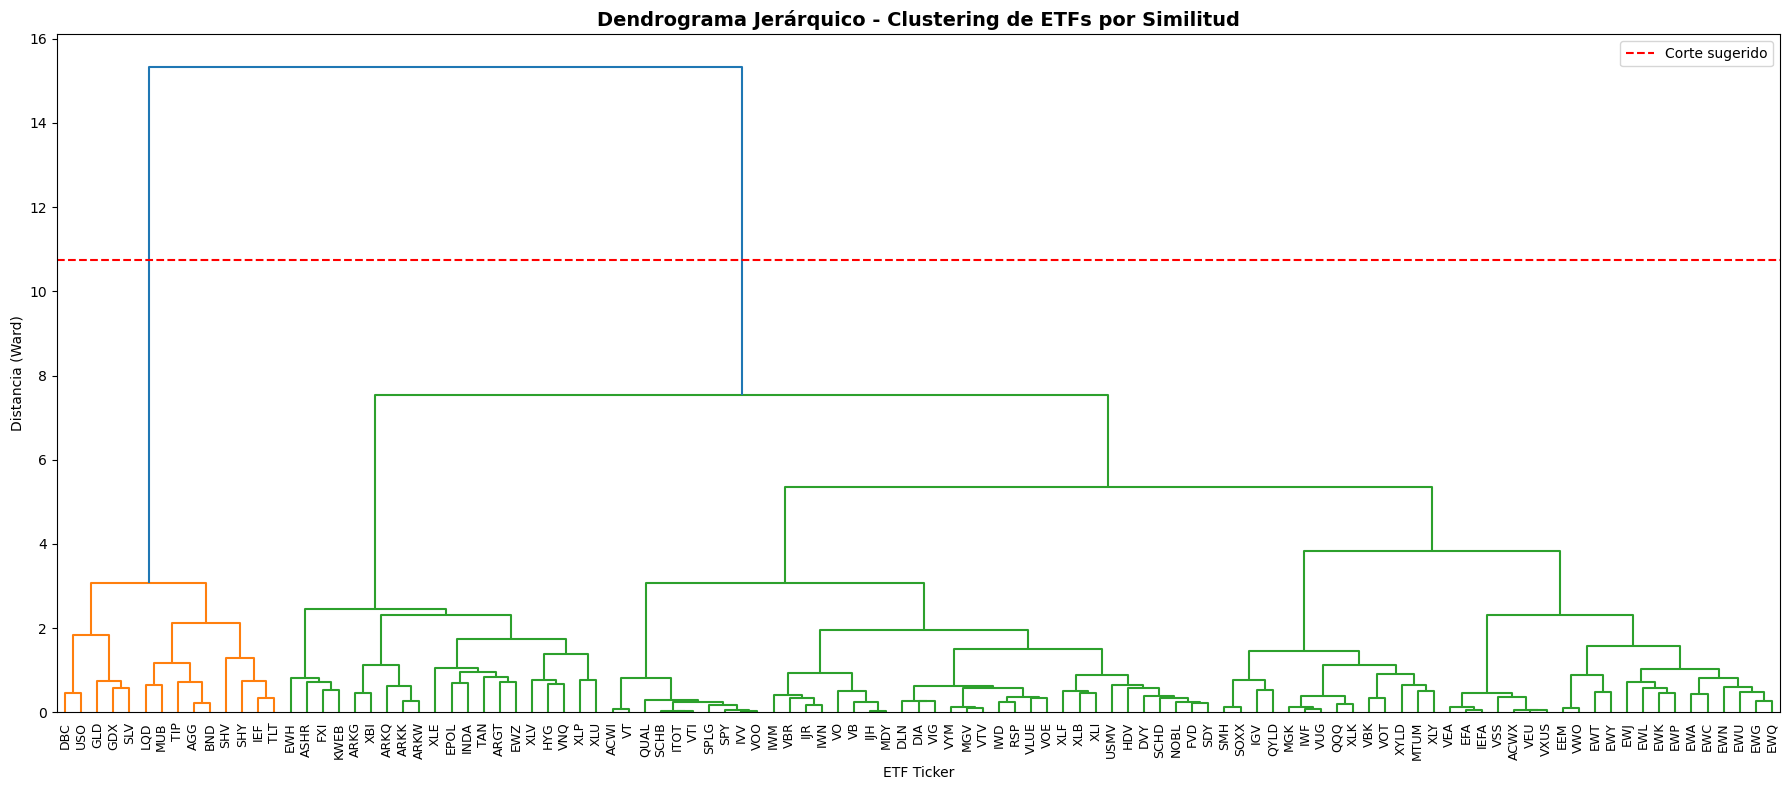


📊 RESULTADOS CLUSTERING:
   Número de clusters: 8
   Silhouette Score: 0.1035
   ⚠️  Clusters ambiguos
   
📋 DISTRIBUCIÓN DE ETFS POR CLUSTER:

   Cluster 1: 5 ETFs
      GLD, GDX, SLV, USO, DBC
   Cluster 2: 9 ETFs
      SHY, IEF, TIP, LQD, SHV...
   Cluster 3: 4 ETFs
      KWEB, ASHR, EWH, FXI
   Cluster 4: 16 ETFs
      INDA, EWZ, ARGT, VNQ, TAN...
   Cluster 5: 10 ETFs
      SPY, IVV, SPLG, SCHB, ITOT...
   Cluster 6: 28 ETFs
      XLI, XLF, SCHD, SDY, XLB...
   Cluster 7: 14 ETFs
      QYLD, QQQ, XLK, VOT, VUG...
   Cluster 8: 21 ETFs
      ACWX, EEM, EFA, EWA, EWC...

🎯 REPRESENTANTES SELECCIONADOS (1 por cluster):


,Cluster,Representative,Sharpe,Members
0,1,GLD,0.7177,5
1,2,LQD,-0.0564,9
2,3,KWEB,0.1358,4
3,4,ARKQ,0.6491,16
4,5,SPLG,0.6484,10
5,6,VIG,0.6069,28
6,7,SMH,0.8825,14
7,8,EWT,0.6097,21


In [27]:
# ---------------------------
# 4.3) CLUSTERING JERÁRQUICO
# ---------------------------

"""
¿POR QUÉ CLUSTERING?
-------------------
Problema: Tenemos 100+ ETFs, muchos redundantes (H3 validó esto)
Solución: Agrupar ETFs similares y seleccionar 1 representante por cluster

MÉTODO: Hierarchical Clustering con Ward Linkage
- Ward minimiza varianza intra-cluster
- Crea dendrograma (árbol de similitud)
- Cortar árbol a altura k define k clusters

APLICACIÓN PRÁCTICA:
- Identificar ETFs redundantes (mismo cluster)
- Seleccionar representantes diversos para portfolio
- Reducir dimensionalidad sin perder información
"""

print("\n" + "="*80)
print("CLUSTERING JERÁRQUICO - IDENTIFICACIÓN DE GRUPOS")
print("="*80)

# Convertir correlación a distancia métrica
# Distancia = √(0.5 × (1 - correlación))
# Propiedad: alta correlación → distancia pequeña
dist = np.sqrt(0.5 * (1 - corr))

# Hierarchical clustering con método Ward
Z = linkage(dist, method='ward')

# Dendrograma
plt.figure(figsize=(18, 8))
dendrogram(
    Z, 
    labels=corr.columns, 
    leaf_rotation=90, 
    leaf_font_size=9,
    color_threshold=0.7*max(Z[:,2])
)
plt.title("Dendrograma Jerárquico - Clustering de ETFs por Similitud", 
          fontsize=14, fontweight='bold')
plt.xlabel("ETF Ticker")
plt.ylabel("Distancia (Ward)")
plt.axhline(y=0.7*max(Z[:,2]), color='red', linestyle='--', 
            label='Corte sugerido')
plt.legend()
plt.tight_layout()
plt.savefig("06_dendrogram.png", dpi=150)
plt.show()

# Asignar clusters (k=8 como ejemplo)
k = 8
clusters = fcluster(Z, k, criterion='maxclust')

cluster_df = pd.DataFrame({
    'Ticker': corr.columns, 
    'Cluster': clusters
}).sort_values('Cluster')

# Calcular Silhouette Score (métrica de calidad)
# Score cercano a 1 → clusters bien definidos
# Score cercano a 0 → clusters ambiguos
sil_score = silhouette_score(dist, clusters, metric='precomputed')

print(f"""
📊 RESULTADOS CLUSTERING:
   Número de clusters: {k}
   Silhouette Score: {sil_score:.4f}
   {'✅ Clusters bien definidos' if sil_score > 0.5 else '⚠️  Clusters ambiguos'}
   
📋 DISTRIBUCIÓN DE ETFS POR CLUSTER:
""")

for cluster_id in range(1, k+1):
    members = cluster_df[cluster_df['Cluster'] == cluster_id]['Ticker'].tolist()
    print(f"   Cluster {cluster_id}: {len(members)} ETFs")
    print(f"      {', '.join(members[:5])}{'...' if len(members) > 5 else ''}")

# Guardar resultados
cluster_df.to_csv("etf_clusters.csv", index=False)

conn = sqlite3.connect(DB_PATH)
cluster_df.to_sql("clusters", conn, if_exists="replace", index=False)
conn.close()

# Seleccionar representantes por cluster (mejor Sharpe en cada cluster)
representatives = []

for cluster_id in range(1, k+1):
    cluster_tickers = cluster_df[cluster_df['Cluster'] == cluster_id]['Ticker'].tolist()
    cluster_stats = stats_df.loc[stats_df.index.intersection(cluster_tickers)]
    
    if not cluster_stats.empty:
        best_ticker = cluster_stats['Sharpe_RF_Adj'].idxmax()
        representatives.append({
            'Cluster': cluster_id,
            'Representative': best_ticker,
            'Sharpe': cluster_stats.loc[best_ticker, 'Sharpe_RF_Adj'],
            'Members': len(cluster_tickers)
        })

rep_df = pd.DataFrame(representatives)

print("\n🎯 REPRESENTANTES SELECCIONADOS (1 por cluster):")
display(rep_df)

rep_df.to_csv("etf_cluster_representatives.csv", index=False)


In [ ]:
# ---------------------------
# INTERPRETACIÓN DE CLUSTERS
# ---------------------------

"""
Identificar asset class dominante en cada cluster
basándose en la categorización de TICKERS
"""

def identify_asset_class(ticker_list):
    """Identifica asset class dominante en lista de ETFs."""
    
    # Categorías basadas en TICKERS definition
    categories = {
        'US_Equity': ['SPY', 'IVV', 'VOO', 'VTI', 'SCHB', 'ITOT', 'SPLG', 
                      'QQQ', 'IWM', 'VB', 'DIA', 'MDY', 'IJH', 'VO'],
        'Sectors': ['XLK', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLU', 'XLC'],
        'International': ['VEA', 'IEFA', 'EFA', 'VEU', 'EEM', 'VWO', 'FXI', 
                         'EWT', 'EWH', 'EWG', 'EWJ', 'EWL', 'EWP', 'EWQ', 'EWZ'],
        'Bonds': ['TLT', 'IEF', 'AGG', 'LQD', 'HYG', 'BND', 'TIP', 'SHV', 'SHY', 'MUB'],
        'Commodities': ['GDX', 'GLD', 'SLV', 'DBC', 'USO'],
        'Dividends': ['SCHD', 'VIG', 'SDY', 'VYM', 'DVY', 'HDV', 'DLN', 'FVD', 'NOBL'],
        'Factor': ['USMV', 'QUAL', 'MTUM', 'VLUE', 'RSP'],
        'Thematic': ['XBI', 'SMH', 'SOXX', 'IGV', 'KWEB', 'ASHR', 'TAN', 
                     'ARKK', 'ARKQ', 'ARKW', 'ARKG', 'ARKF']
    }
    
    # Contar membresía por categoría
    counts = {}
    for cat, members in categories.items():
        count = sum(1 for t in ticker_list if t in members)
        counts[cat] = count
    
    # Encontrar categoría dominante
    if max(counts.values()) == 0:
        return "Mixed/Other"
    
    dominant = max(counts, key=counts.get)
    pct = counts[dominant] / len(ticker_list)
    
    return f"{dominant} ({pct:.0%})"

print("\n📋 INTERPRETACIÓN DE CLUSTERS:")
print("="*80)

for cluster_id in range(1, k+1):
    members = cluster_df[cluster_df['Cluster'] == cluster_id]['Ticker'].tolist()
    asset_class = identify_asset_class(members)
    representative = rep_df[rep_df['Cluster']==cluster_id]['Representative'].values[0]
    
    print(f"""
Cluster {cluster_id}: {asset_class}
   Miembros: {len(members)} ETFs
   Representante: {representative}
   Ejemplos: {', '.join(members[:3])}{'...' if len(members) > 3 else ''}
""")


📋 INTERPRETACIÓN DE CLUSTERS:

Cluster 1: Commodities (100%)
   Miembros: 5 ETFs
   Representante: GLD
   Ejemplos: GLD, GDX, SLV...


Cluster 2: Bonds (100%)
   Miembros: 9 ETFs
   Representante: LQD
   Ejemplos: SHY, IEF, TIP...


Cluster 3: International (50%)
   Miembros: 4 ETFs
   Representante: KWEB
   Ejemplos: KWEB, ASHR, EWH...


Cluster 4: Thematic (38%)
   Miembros: 16 ETFs
   Representante: ARKQ
   Ejemplos: INDA, EWZ, ARGT...


Cluster 5: US_Equity (70%)
   Miembros: 10 ETFs
   Representante: SPLG
   Ejemplos: SPY, IVV, SPLG...


Cluster 6: Dividends (32%)
   Miembros: 28 ETFs
   Representante: VIG
   Ejemplos: XLI, XLF, SCHD...


Cluster 7: Thematic (21%)
   Miembros: 14 ETFs
   Representante: SMH
   Ejemplos: QYLD, QQQ, XLK...


Cluster 8: International (57%)
   Miembros: 21 ETFs
   Representante: EWT
   Ejemplos: ACWX, EEM, EFA...




OPTIMIZACIÓN DE PORTAFOLIO - MÉTODO MARKOWITZ (MAX SHARPE)

📊 INPUTS DE OPTIMIZACIÓN:
   Retornos esperados: 107 ETFs
   Matriz covarianza: (107, 107)
   Período histórico: 2514 días
   Restricción: Máximo 10 activos en portafolio


🎯 ETFs SELECCIONADOS (Top 10 por peso inicial):
   1. GLD: 14.24%
   2. SMH: 10.92%
   3. SLV: 6.10%
   4. XLK: 5.90%
   5. GDX: 5.77%
   6. SOXX: 4.15%
   7. QQQ: 3.82%
   8. SHV: 3.42%
   9. XLU: 2.99%
   10. IWF: 2.90%

⚙️  Re-optimizando con 10 ETFs seleccionados...

🎯 PORTAFOLIO ÓPTIMO FINAL (MAX SHARPE):
   Número de activos: 10

📋 ASIGNACIÓN DE CAPITAL:


,Weight
GLD,0.18653
SMH,0.17283
XLK,0.11180
SLV,0.08908
SOXX,0.08581
GDX,0.08552
QQQ,0.08313
IWF,0.07319
XLU,0.06727
SHV,0.04485



📊 MÉTRICAS ESPERADAS (ex-ante):
   Retorno anualizado: 20.09%
   Volatilidad anualizada: 17.60%
   Sharpe Ratio: 1.1413


📈 Graficando Frontera Eficiente...


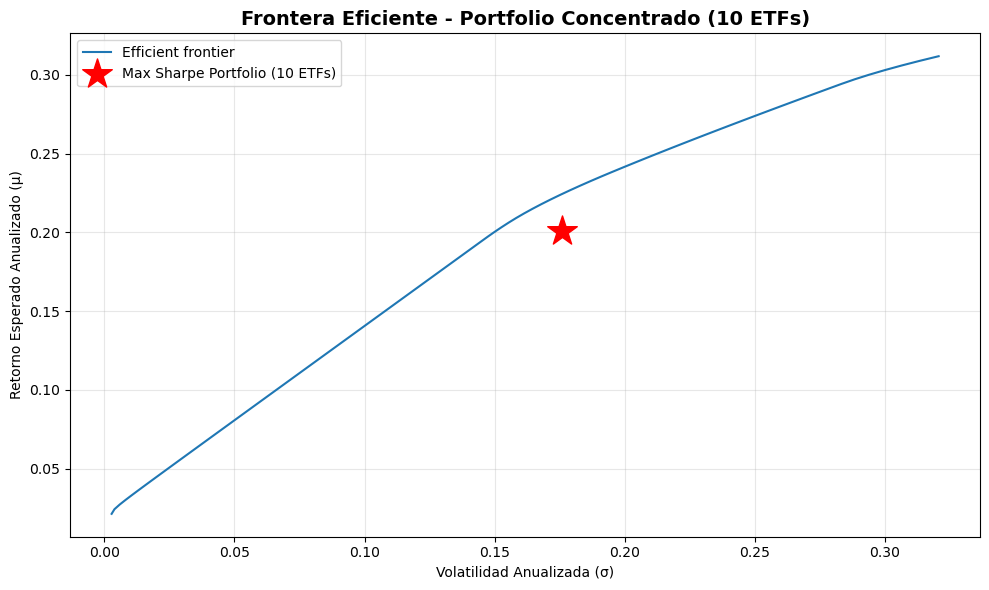

In [29]:
# ---------------------------
# 4.4) OPTIMIZACIÓN DE PORTAFOLIO - MARKOWITZ
# ---------------------------

"""
TEORÍA MODERNA DE PORTAFOLIO (MPT)
----------------------------------
Pregunta central: ¿Cómo asignar capital para maximizar retorno/riesgo?

MODELO DE MARKOWITZ:
Maximizar: Sharpe Ratio = (μ_p - r_f) / σ_p
Sujeto a:
  - Σ w_i = 1 (fully invested)
  - w_i ≥ 0 (no short selling)
  - w^T Σ w minimizado (riesgo portafolio)

SUPUESTOS CRÍTICOS:
1. Retornos futuros ~ retornos históricos (μ estable)
2. Covarianzas futuras ~ covarianzas históricas (Σ estable)
3. Distribución normal de retornos

REGULARIZACIÓN L2:
Penaliza pesos extremos: min(w^T Σ w + γ||w||²)
γ = 0.1 → penalización moderada (evita concentración excesiva)

RESTRICCIÓN DE CARDINALIDAD:
Limitamos a máximo 10 ETFs para:
  - Simplicidad operativa (menos rebalanceos)
  - Costos de transacción reducidos
  - Portfolio práctico e implementable
"""

print("\n" + "="*80)
print("OPTIMIZACIÓN DE PORTAFOLIO - MÉTODO MARKOWITZ (MAX SHARPE)")
print("="*80)

# Calcular inputs de optimización
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

print(f"""
📊 INPUTS DE OPTIMIZACIÓN:
   Retornos esperados: {len(mu)} ETFs
   Matriz covarianza: {S.shape}
   Período histórico: {len(prices)} días
   Restricción: Máximo 10 activos en portafolio
""")

# PASO 1: Optimización sin restricción de cardinalidad (para identificar candidatos)
ef_initial = EfficientFrontier(mu, S)
ef_initial.add_objective(objective_functions.L2_reg, gamma=0.1)
initial_weights = ef_initial.max_sharpe()
initial_cleaned = ef_initial.clean_weights()

# Ordenar por peso y seleccionar top 10
top_10_etfs = sorted(initial_cleaned.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_tickers = [etf for etf, _ in top_10_etfs if _ > 0]

print(f"\n🎯 ETFs SELECCIONADOS (Top 10 por peso inicial):")
for i, (etf, weight) in enumerate(top_10_etfs, 1):
    if weight > 0:
        print(f"   {i}. {etf}: {weight:.2%}")

# PASO 2: Re-optimizar solo con los 10 ETFs seleccionados
mu_filtered = mu[top_10_tickers]
S_filtered = S.loc[top_10_tickers, top_10_tickers]

ef = EfficientFrontier(mu_filtered, S_filtered)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)

print("\n⚙️  Re-optimizando con 10 ETFs seleccionados...")

# Maximizar Sharpe Ratio
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Todos los pesos son significativos ahora (solo 10 activos)
significant_weights = {k: v for k, v in cleaned_weights.items() if v > 0.0001}

print(f"\n🎯 PORTAFOLIO ÓPTIMO FINAL (MAX SHARPE):")
print(f"   Número de activos: {len(significant_weights)}")

weights_df = pd.DataFrame.from_dict(significant_weights, orient='index', columns=['Weight'])
weights_df = weights_df.sort_values('Weight', ascending=False)

print("\n📋 ASIGNACIÓN DE CAPITAL:")
display(weights_df)

# Performance esperada
expected_return, expected_vol, expected_sharpe = ef.portfolio_performance(verbose=False, risk_free_rate=0.04)

print(f"""
📊 MÉTRICAS ESPERADAS (ex-ante):
   Retorno anualizado: {expected_return:.2%}
   Volatilidad anualizada: {expected_vol:.2%}
   Sharpe Ratio: {expected_sharpe:.4f}
""")

# Guardar pesos
weights_df.to_csv("portfolio_markowitz_weights.csv")

conn = sqlite3.connect(DB_PATH)
weights_df.to_sql("markowitz_weights", conn, if_exists="replace", index=True)
conn.close()

# Frontera eficiente (con los 10 ETFs seleccionados)
print("\n📈 Graficando Frontera Eficiente...")

ef_plot = EfficientFrontier(mu_filtered, S_filtered)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot frontera
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)

# Marcar portafolio óptimo
ax.scatter(expected_vol, expected_return, marker='*', s=500, c='red', 
           label='Max Sharpe Portfolio (10 ETFs)', zorder=3)

ax.set_title("Frontera Eficiente - Portfolio Concentrado (10 ETFs)", fontsize=14, fontweight='bold')
ax.set_xlabel("Volatilidad Anualizada (σ)")
ax.set_ylabel("Retorno Esperado Anualizado (μ)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("07_efficient_frontier.png", dpi=150)
plt.show()


OPTIMIZACIÓN ALTERNATIVA - HIERARCHICAL RISK PARITY (HRP)

📊 UNIVERSO DE INVERSIÓN HRP:
   Estrategia: 1 representante por cluster
   Número de activos: 8
   ETFs seleccionados: GLD, LQD, KWEB, ARKQ, SPLG, VIG, SMH, EWT
   
💡 Justificación: Usar representantes elimina redundancia detectada en H3
                  y permite comparación justa con Markowitz (similar cardinalidad)

⚙️  Calculando HRP con universo reducido...

🎯 PORTAFOLIO HRP:
   Número de activos: 8

📋 ASIGNACIÓN DE CAPITAL:


,Weight
LQD,0.415961
KWEB,0.254037
EWT,0.173016
SPLG,0.077267
ARKQ,0.056176
VIG,0.010969
GLD,0.008734
SMH,0.003839



📊 MÉTRICAS ESPERADAS HRP:
   Retorno anualizado: 9.68%
   Volatilidad anualizada: 15.91%
   Sharpe Ratio: 0.3569



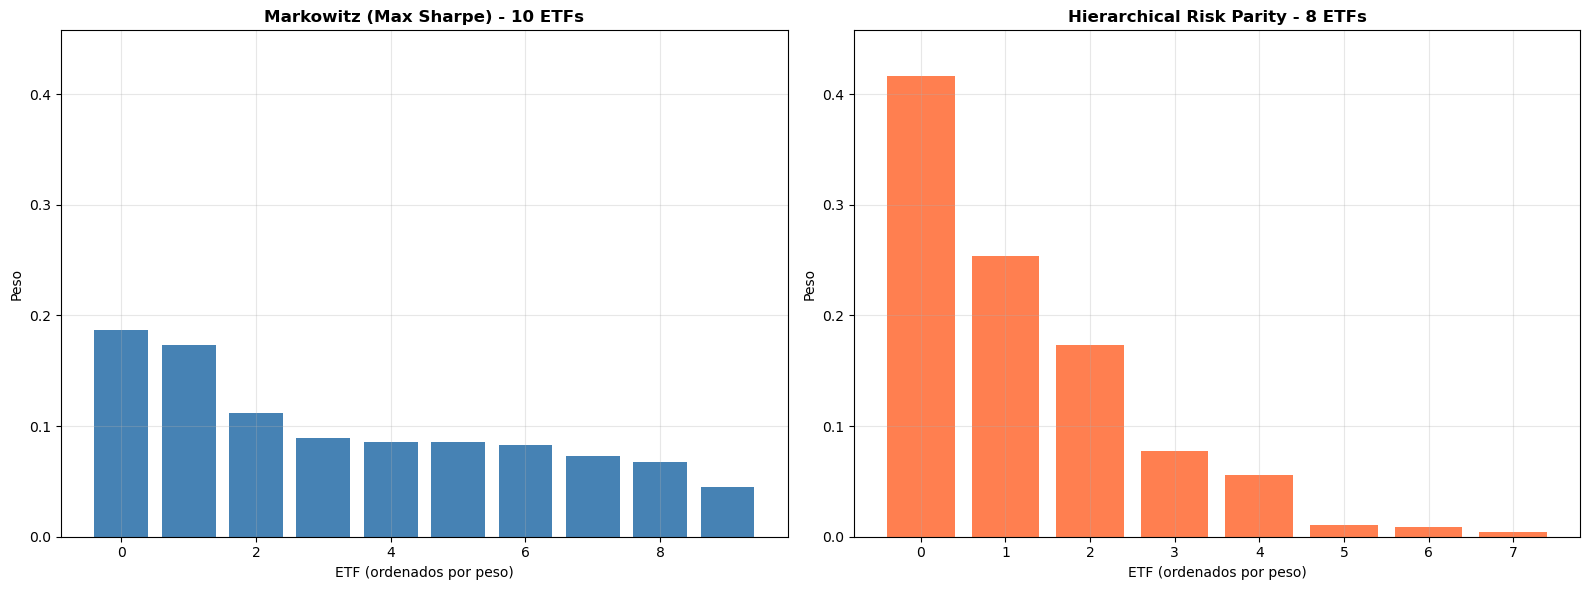


💡 COMPARACIÓN MARKOWITZ vs HRP:
   
   CONCENTRACIÓN:
   • Markowitz: Top 3 ETFs = 47.1% del portfolio
   • HRP: Top 3 ETFs = 84.3% del portfolio
   
   SHARPE ESPERADO:
   • Markowitz: 1.1413
   • HRP: 0.3569
   • Diferencia: +0.7843
   
   FILOSOFÍA:
   • Markowitz: Maximiza retorno/riesgo (usa μ + Σ)
   • HRP: Distribuye riesgo equitativamente (usa solo Σ)
   
   TRADE-OFF:
   • Markowitz: Mayor Sharpe esperado, pero sensible a errores en μ
   • HRP: Menor Sharpe esperado, pero más robusto out-of-sample



In [30]:
# ---------------------------
# 4.5) HIERARCHICAL RISK PARITY (HRP)
# ---------------------------

"""
LIMITACIONES DE MARKOWITZ:
--------------------------
1. Sensible a estimación de μ (error en inputs → pesos inestables)
2. Concentración en pocos activos (sin regularización fuerte)
3. Asume normalidad y estacionariedad

ALTERNATIVA: HRP (López de Prado, 2016)
--------------------------------------
No usa retornos esperados, solo covarianzas
Proceso:
1. Clustering jerárquico (dendrograma)
2. Inversión recursiva de varianza dentro de clusters
3. Asignación basada en contribución al riesgo

VENTAJAS:
✓ Estable (no depende de μ)
✓ Diversificado (distribuye riesgo equitativamente)
✓ Out-of-sample performance superior en alta incertidumbre

RESTRICCIÓN DE UNIVERSO:
Para comparación justa con Markowitz, usamos los MISMOS representantes
de clusters identificados anteriormente (1 ETF por cluster = 8 activos).
Esto permite evaluar HRP vs Markowitz en igualdad de condiciones.

CUÁNDO USAR:
- Datos limitados o ruidosos
- Desconfianza en estimaciones de μ
- Prioridad en estabilidad long-term
"""

print("\n" + "="*80)
print("OPTIMIZACIÓN ALTERNATIVA - HIERARCHICAL RISK PARITY (HRP)")
print("="*80)

# PASO 1: Seleccionar universo reducido (representantes de clusters)
cluster_representatives = rep_df['Representative'].tolist()

print(f"""
📊 UNIVERSO DE INVERSIÓN HRP:
   Estrategia: 1 representante por cluster
   Número de activos: {len(cluster_representatives)}
   ETFs seleccionados: {', '.join(cluster_representatives)}
   
💡 Justificación: Usar representantes elimina redundancia detectada en H3
                  y permite comparación justa con Markowitz (similar cardinalidad)
""")

# PASO 2: Filtrar precios solo para representantes
prices_hrp = prices[cluster_representatives]

print("⚙️  Calculando HRP con universo reducido...")

hrp = HRPOpt(prices_hrp)
hrp_weights = hrp.optimize()

# Todos los pesos son significativos (solo 8 activos)
hrp_significant = {k: v for k, v in hrp_weights.items() if v > 0.0001}

print(f"\n🎯 PORTAFOLIO HRP:")
print(f"   Número de activos: {len(hrp_significant)}")

hrp_df = pd.DataFrame.from_dict(hrp_significant, orient='index', columns=['Weight'])
hrp_df = hrp_df.sort_values('Weight', ascending=False)

print("\n📋 ASIGNACIÓN DE CAPITAL:")
display(hrp_df)

# Calcular métricas esperadas (para comparación)
rets_hrp = prices_hrp.pct_change().dropna()
hrp_series = pd.Series(hrp_weights)
hrp_port_ret = (rets_hrp * hrp_series).sum(axis=1)
hrp_ann_ret = hrp_port_ret.mean() * 252
hrp_ann_vol = hrp_port_ret.std() * np.sqrt(252)
hrp_sharpe = (hrp_ann_ret - 0.04) / hrp_ann_vol

print(f"""
📊 MÉTRICAS ESPERADAS HRP:
   Retorno anualizado: {hrp_ann_ret:.2%}
   Volatilidad anualizada: {hrp_ann_vol:.2%}
   Sharpe Ratio: {hrp_sharpe:.4f}
""")

# Guardar pesos
hrp_df.to_csv("portfolio_hrp_weights.csv")

conn = sqlite3.connect(DB_PATH)
hrp_df.to_sql("hrp_weights", conn, if_exists="replace", index=True)
conn.close()

# Comparación visual: Markowitz vs HRP
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Markowitz
axes[0].bar(range(len(weights_df)), weights_df['Weight'].values, color='steelblue')
axes[0].set_title(f"Markowitz (Max Sharpe) - {len(weights_df)} ETFs", fontweight='bold')
axes[0].set_xlabel("ETF (ordenados por peso)")
axes[0].set_ylabel("Peso")
axes[0].set_ylim(0, max(weights_df['Weight'].max(), hrp_df['Weight'].max()) * 1.1)
axes[0].grid(True, alpha=0.3)

# HRP
axes[1].bar(range(len(hrp_df)), hrp_df['Weight'].values, color='coral')
axes[1].set_title(f"Hierarchical Risk Parity - {len(hrp_df)} ETFs", fontweight='bold')
axes[1].set_xlabel("ETF (ordenados por peso)")
axes[1].set_ylabel("Peso")
axes[1].set_ylim(0, max(weights_df['Weight'].max(), hrp_df['Weight'].max()) * 1.1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("08_portfolio_comparison.png", dpi=150)
plt.show()

print(f"""
💡 COMPARACIÓN MARKOWITZ vs HRP:
   
   CONCENTRACIÓN:
   • Markowitz: Top 3 ETFs = {weights_df.head(3)['Weight'].sum():.1%} del portfolio
   • HRP: Top 3 ETFs = {hrp_df.head(3)['Weight'].sum():.1%} del portfolio
   
   SHARPE ESPERADO:
   • Markowitz: {expected_sharpe:.4f}
   • HRP: {hrp_sharpe:.4f}
   • Diferencia: {expected_sharpe - hrp_sharpe:+.4f}
   
   FILOSOFÍA:
   • Markowitz: Maximiza retorno/riesgo (usa μ + Σ)
   • HRP: Distribuye riesgo equitativamente (usa solo Σ)
   
   TRADE-OFF:
   • Markowitz: Mayor Sharpe esperado, pero sensible a errores en μ
   • HRP: Menor Sharpe esperado, pero más robusto out-of-sample
""")



BACKTESTING - VALIDACIÓN DE PERFORMANCE HISTÓRICA

📊 Backtesting Portafolio Markowitz...
📊 Backtesting Portafolio HRP...
📊 Backtesting Benchmark 60/40...

📊 COMPARACIÓN DE PERFORMANCE:


,Ann_Return,Ann_Vol,Sharpe,Sortino,Max_DD,Calmar,Total_Return
Markowitz,0.2168,0.1762,1.0037,1.3259,-0.2751,0.8102,6.3322
HRP,0.1007,0.1591,0.3816,0.5407,-0.4362,0.2110,1.3915
60/40 Passive,0.1040,0.1123,0.5699,0.6823,-0.2172,0.4724,1.6299


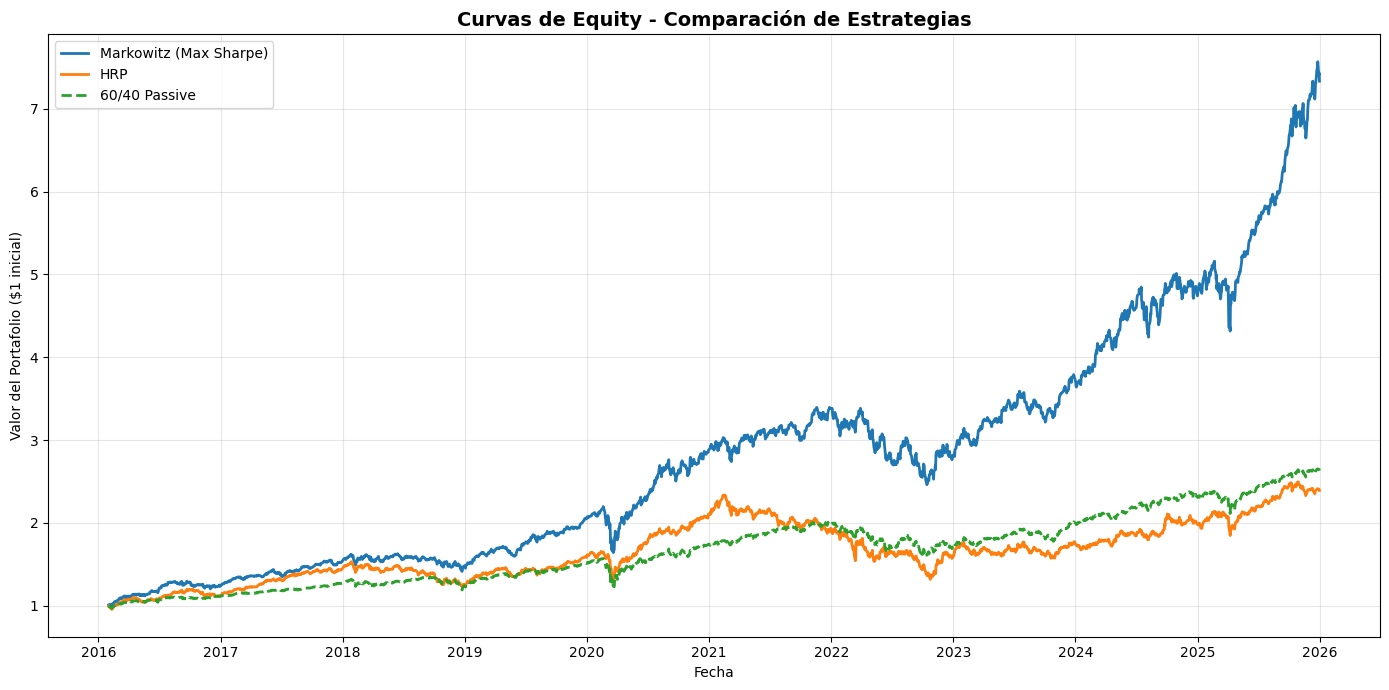

In [31]:
# ---------------------------
# 4.6) BACKTESTING - VALIDACIÓN EX-POST
# ---------------------------

"""
LOOKBACK BIAS WARNING:
---------------------
⚠️  La optimización usa TODO el histórico
⚠️  En realidad, solo conoces el pasado al momento de decidir
⚠️  Este backtest es OPTIMISTA (mira el futuro)

BACKTESTING HONESTO requiere:
1. Rolling windows (reoptimizar periódicamente)
2. Out-of-sample testing (train/test split)
3. Walk-forward analysis

ESTE BACKTEST:
- Rebalancea mensualmente con pesos fijos
- Ignora costos transaccionales (bid-ask, comisiones)
- Ignora slippage (diferencia precio teórico vs ejecutado)
- Ignora market impact (tus órdenes mueven el precio)

INTERPRETACIÓN:
Performance aquí = UPPER BOUND del resultado real
"""

print("\n" + "="*80)
print("BACKTESTING - VALIDACIÓN DE PERFORMANCE HISTÓRICA")
print("="*80)

def backtest_portfolio(prices, weights, rebalance_freq='M', start_date=None):
    """
    Simula performance histórica de un portafolio con rebalanceo periódico.
    
    Parameters:
    ----------
    prices : pd.DataFrame
        Precios ajustados
    weights : dict
        Diccionario {ticker: peso}
    rebalance_freq : str
        'M' = mensual, 'Q' = trimestral
    
    Returns:
    -------
    pd.Series: Retornos diarios del portafolio
    """
    
    # Filtrar precios de activos en portafolio
    portfolio_tickers = list(weights.keys())
    prices_port = prices[portfolio_tickers].copy()
    
    # Calcular retornos diarios
    returns = prices_port.pct_change().fillna(0)
    
    # Fechas de rebalanceo
    rebal_dates = prices_port.resample(rebalance_freq).last().index
    
    # Inicializar serie de retornos del portafolio
    port_returns = []
    
    for i in range(1, len(rebal_dates)):
        # Periodo entre rebalanceos
        period_mask = (returns.index > rebal_dates[i-1]) & (returns.index <= rebal_dates[i])
        period_rets = returns.loc[period_mask]
        
        # Calcular retorno ponderado del portafolio cada día
        weights_series = pd.Series(weights)
        daily_port_ret = (period_rets * weights_series).sum(axis=1)
        
        port_returns.append(daily_port_ret)
    
    # Concatenar todos los periodos
    port_series = pd.concat(port_returns).sort_index()
    
    return port_series

# Backtest Markowitz
print("\n📊 Backtesting Portafolio Markowitz...")
port_ret_markowitz = backtest_portfolio(prices, significant_weights, rebalance_freq='M')

# Backtest HRP
print("📊 Backtesting Portafolio HRP...")
port_ret_hrp = backtest_portfolio(prices, hrp_significant, rebalance_freq='M')

# Backtest 60/40 (benchmark pasivo)
print("📊 Backtesting Benchmark 60/40...")
weights_6040 = {'SPY': 0.6, 'AGG': 0.4}
port_ret_6040 = backtest_portfolio(prices, weights_6040, rebalance_freq='M')

# Calcular métricas de performance
def portfolio_metrics(returns, rf_rate=0.04):
    """Calcula métricas comprehensivas de un portafolio."""
    
    ann_ret = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = (ann_ret - rf_rate) / ann_vol
    
    # Drawdown
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    
    # Calmar Ratio
    cagr = (cumulative.iloc[-1] ** (252 / len(cumulative))) - 1
    calmar = cagr / abs(max_dd) if max_dd != 0 else np.nan
    
    # Sortino
    downside_rets = returns[returns < 0]
    downside_vol = downside_rets.std() * np.sqrt(252)
    sortino = (ann_ret - rf_rate) / downside_vol if downside_vol > 0 else np.nan
    
    return {
        'Ann_Return': ann_ret,
        'Ann_Vol': ann_vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD': max_dd,
        'Calmar': calmar,
        'Total_Return': cumulative.iloc[-1] - 1
    }

# Calcular métricas
metrics_markowitz = portfolio_metrics(port_ret_markowitz)
metrics_hrp = portfolio_metrics(port_ret_hrp)
metrics_6040 = portfolio_metrics(port_ret_6040)

# Tabla comparativa
comparison = pd.DataFrame({
    'Markowitz': metrics_markowitz,
    'HRP': metrics_hrp,
    '60/40 Passive': metrics_6040
}).T

print("\n📊 COMPARACIÓN DE PERFORMANCE:")
display(comparison.round(4))

# Guardar métricas
comparison.to_csv("portfolio_performance_comparison.csv")

conn = sqlite3.connect(DB_PATH)
comparison.to_sql("portfolio_performance", conn, if_exists="replace", index=True)
conn.close()

# Curvas de equity
cumulative_markowitz = (1 + port_ret_markowitz).cumprod()
cumulative_hrp = (1 + port_ret_hrp).cumprod()
cumulative_6040 = (1 + port_ret_6040).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cumulative_markowitz.index, cumulative_markowitz.values, 
         label='Markowitz (Max Sharpe)', linewidth=2)
plt.plot(cumulative_hrp.index, cumulative_hrp.values, 
         label='HRP', linewidth=2)
plt.plot(cumulative_6040.index, cumulative_6040.values, 
         label='60/40 Passive', linewidth=2, linestyle='--')

plt.title("Curvas de Equity - Comparación de Estrategias", fontsize=14, fontweight='bold')
plt.xlabel("Fecha")
plt.ylabel("Valor del Portafolio ($1 inicial)")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("09_equity_curves.png", dpi=150)
plt.show()


ANÁLISIS DE DRAWDOWN


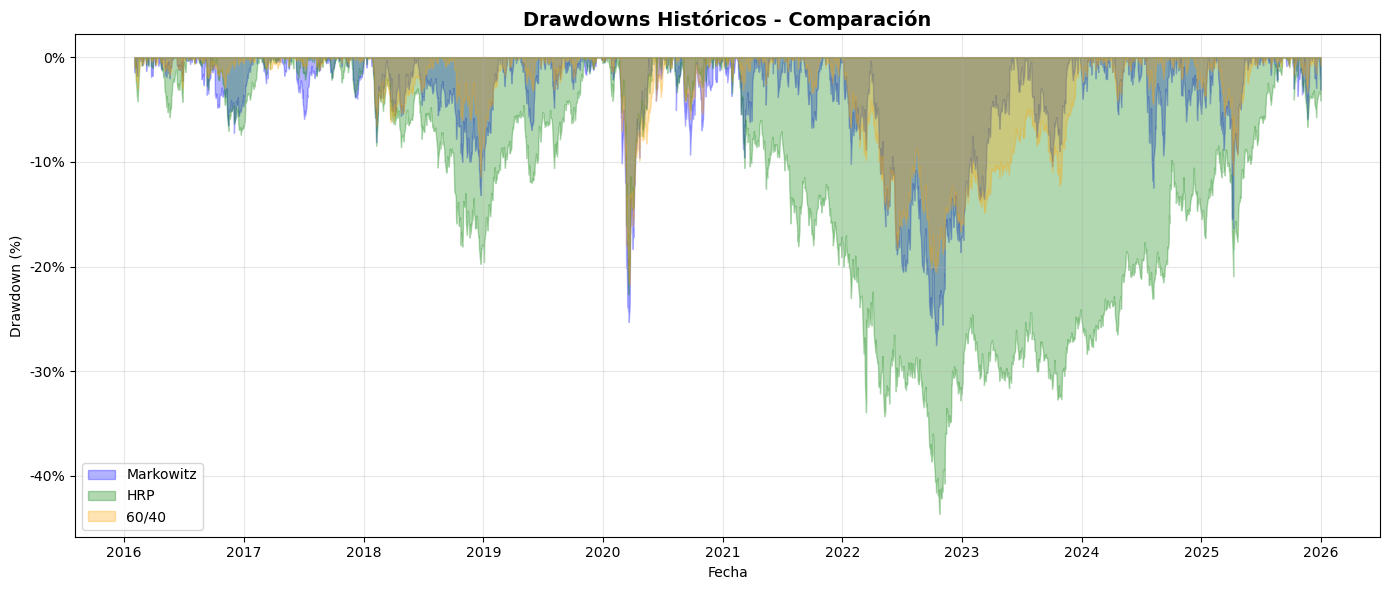


📊 MAX DRAWDOWNS:
   Markowitz: -27.51%
   HRP: -43.62%
   60/40 Passive: -21.72%



In [32]:
# ---------------------------
# 4.7) ANÁLISIS DE DRAWDOWN
# ---------------------------

"""
DRAWDOWN: Pérdida desde pico histórico más reciente
----------------------------------------------------
Fórmula: DD_t = (Valor_t - Pico_previo) / Pico_previo

¿POR QUÉ IMPORTA?
- Mide "dolor" del inversor
- Alto Sharpe + alto Max DD = experiencia emocional difícil
- Drawdown prolongado → riesgo de abandono de estrategia

MÉTRICAS DERIVADAS:
- Max Drawdown: Peor pérdida histórica
- Drawdown Duration: Días bajo agua (underwater)
- Calmar Ratio: CAGR / |Max DD| (retorno por unidad de drawdown)
"""

print("\n" + "="*80)
print("ANÁLISIS DE DRAWDOWN")
print("="*80)

def compute_drawdown(cum_returns):
    """Calcula serie de drawdowns."""
    peak = cum_returns.cummax()
    dd = (cum_returns - peak) / peak
    return dd

# Calcular drawdowns
dd_markowitz = compute_drawdown(cumulative_markowitz)
dd_hrp = compute_drawdown(cumulative_hrp)
dd_6040 = compute_drawdown(cumulative_6040)

# Visualizar
plt.figure(figsize=(14, 6))
plt.fill_between(dd_markowitz.index, 0, dd_markowitz.values, 
                 alpha=0.3, label='Markowitz', color='blue')
plt.fill_between(dd_hrp.index, 0, dd_hrp.values, 
                 alpha=0.3, label='HRP', color='green')
plt.fill_between(dd_6040.index, 0, dd_6040.values, 
                 alpha=0.3, label='60/40', color='orange')

plt.title("Drawdowns Históricos - Comparación", fontsize=14, fontweight='bold')
plt.xlabel("Fecha")
plt.ylabel("Drawdown (%)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("10_drawdowns.png", dpi=150)
plt.show()

print(f"""
📊 MAX DRAWDOWNS:
   Markowitz: {dd_markowitz.min():.2%}
   HRP: {dd_hrp.min():.2%}
   60/40 Passive: {dd_6040.min():.2%}
""")


In [33]:
# ---------------------------
# 4.8) VAR Y CVAR - TAIL RISK
# ---------------------------

"""
VALUE AT RISK (VaR):
-------------------
Pregunta: ¿Cuánto puedo perder en un día malo?

VaR_α = Percentil α de la distribución de retornos
Ej: VaR 95% = -2.5% → "95% de días, no pierdo más de 2.5%"

MÉTODOS:
1. Histórico: Percentil empírico (no paramétrico)
2. Paramétrico: Asume normalidad μ + σ × Z_α

CONDITIONAL VAR (CVaR / ES):
---------------------------
Pregunta: Si caigo en el 5% peor, ¿cuánto pierdo en promedio?

CVaR_α = E[Retorno | Retorno ≤ VaR_α]

CVaR es COHERENTE (satisface propiedades deseables)
VaR NO es coherente (no es subaditivo)

INTERPRETACIÓN:
VaR: Umbral del desastre
CVaR: Magnitud promedio del desastre
"""

print("\n" + "="*80)
print("ANÁLISIS DE RIESGO DE COLA - VAR Y CVAR")
print("="*80)

def calculate_var_cvar(returns, confidence_level=0.95):
    """Calcula VaR y CVaR histórico y paramétrico."""
    
    alpha = 1 - confidence_level
    
    # Método histórico
    var_hist = returns.quantile(alpha)
    cvar_hist = returns[returns <= var_hist].mean()
    
    # Método paramétrico (asume normalidad)
    mu = returns.mean()
    sigma = returns.std()
    var_param = mu + sigma * stats.norm.ppf(alpha)
    cvar_param = mu - sigma * stats.norm.pdf(stats.norm.ppf(alpha)) / alpha
    
    return {
        'VaR_Historical': var_hist,
        'CVaR_Historical': cvar_hist,
        'VaR_Parametric': var_param,
        'CVaR_Parametric': cvar_param
    }

# Calcular para cada portafolio
risk_markowitz = calculate_var_cvar(port_ret_markowitz, 0.95)
risk_hrp = calculate_var_cvar(port_ret_hrp, 0.95)
risk_6040 = calculate_var_cvar(port_ret_6040, 0.95)

risk_comparison = pd.DataFrame({
    'Markowitz': risk_markowitz,
    'HRP': risk_hrp,
    '60/40 Passive': risk_6040
}).T

print("\n📊 MÉTRICAS DE RIESGO (Confianza 95%):")
display(risk_comparison.round(4))

print("""
💡 INTERPRETACIÓN:
   VaR_Historical > VaR_Parametric → Colas más pesadas que normal
   CVaR mucho peor que VaR → Tail risk significativo
""")



ANÁLISIS DE RIESGO DE COLA - VAR Y CVAR

📊 MÉTRICAS DE RIESGO (Confianza 95%):


,VaR_Historical,CVaR_Historical,VaR_Parametric,CVaR_Parametric
Markowitz,-0.0170,-0.0258,-0.0174,-0.0220
HRP,-0.0151,-0.0222,-0.0161,-0.0203
60/40 Passive,-0.0102,-0.0170,-0.0112,-0.0142



💡 INTERPRETACIÓN:
   VaR_Historical > VaR_Parametric → Colas más pesadas que normal
   CVaR mucho peor que VaR → Tail risk significativo




VALIDACIÓN FINAL DE HIPÓTESIS DE INVESTIGACIÓN

H1: EQUITY vs BONDS - TEST DE SIGNIFICANCIA

📊 ESTADÍSTICAS DESCRIPTIVAS:
   Equity: n=14, μ=0.4992, σ=0.1581
   Bonds:  n=8, μ=-1.2590, σ=2.3098

📈 TEST T (ONE-TAILED):
   t-statistic: 2.8905
   p-value: 0.0045
   Significancia: α=0.05
   
✅ RESULTADO H1: VALIDADA
   ✓ Equity tiene Sharpe significativamente mayor (p=0.0045)



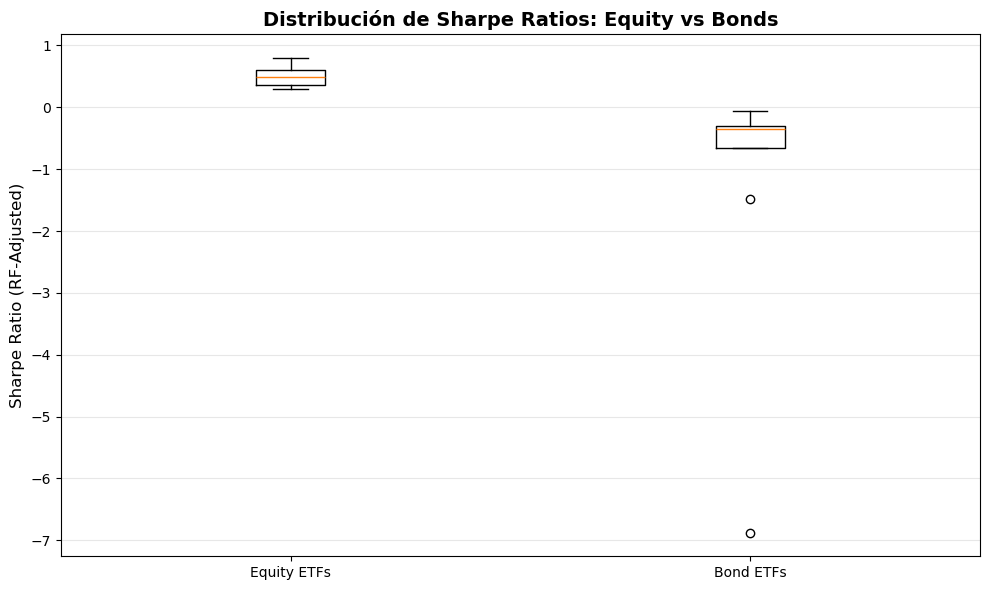


H2: OPTIMIZADO vs 60/40 - COMPARACIÓN DE PERFORMANCE

📊 SHARPE RATIOS:
   Markowitz: 1.0037
   60/40 Passive: 0.5699
   Diferencia: +0.4338 (+76.13%)
   
✅ RESULTADO H2: VALIDADA
   ✓ Optimizado supera pasiva


🔄 Calculando Bootstrap CI (5000 iteraciones)...

📊 INTERVALOS DE CONFIANZA 95% (Bootstrap):
   Markowitz: [0.3569, 1.6277] (median=0.9949)
   60/40:     [-0.0431, 1.1980] (median=0.5720)
   
💡 Interpretación: 
   ⚠️  CIs se solapan → diferencia no concluyente



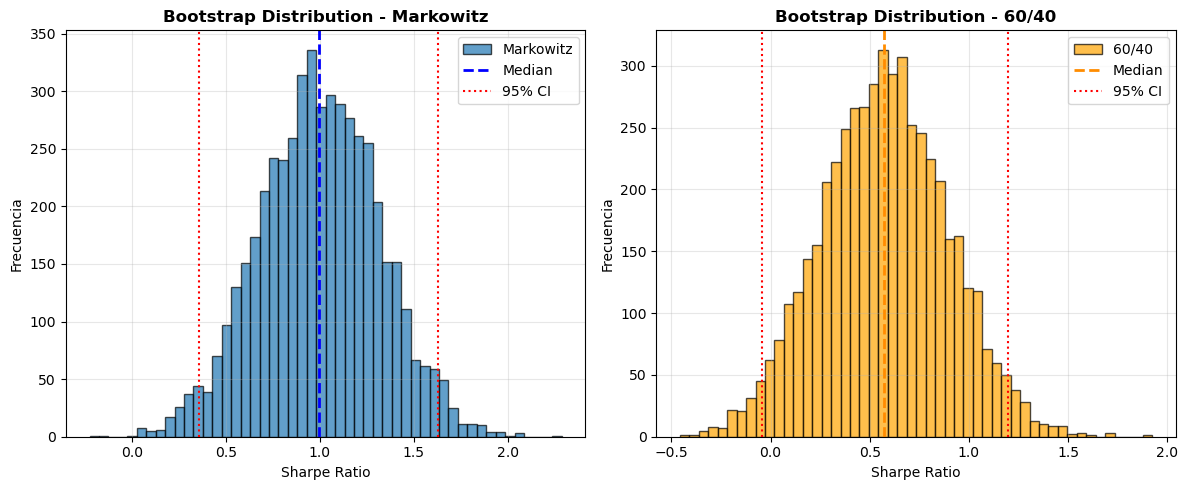


H3: REDUNDANCIA Y CONCENTRACIÓN - RESUMEN

📊 PARTE 1 - CORRELACIONES:
   Pares con corr > 0.9: 568 (10.02%)
   Umbral hipótesis: 30%
   Resultado: RECHAZADA

📊 PARTE 2 - PCA:
   Componentes para 80% varianza: 5
   Umbral hipótesis: ≤5 componentes
   Resultado: VALIDADA - Alta concentración sistémica

💡 IMPLICACIÓN:
   ✓ Nivel aceptable de redundancia
   ⚠️  Riesgo sistémico domina - diversificación limitada



In [34]:
# ============================================================================
# FASE 5: VALIDACIÓN FORMAL DE HIPÓTESIS
# ============================================================================

print("\n" + "="*80)
print("VALIDACIÓN FINAL DE HIPÓTESIS DE INVESTIGACIÓN")
print("="*80)

# ---------------------------
# H1: TEST T - EQUITY VS BONDS
# ---------------------------

"""
H1: "Los ETFs de renta variable son mejor oportunidad que bonos"
----------------------------------------------------------------
Métrica: Sharpe Ratio
Test: t-test de dos muestras independientes
H0: μ_equity = μ_bonds
H1: μ_equity > μ_bonds (one-tailed)
"""

print("\n" + "="*80)
print("H1: EQUITY vs BONDS - TEST DE SIGNIFICANCIA")
print("="*80)

# Definir universos
equity_tickers = [t for t in stats_df.index if t in [
    'SPY', 'QQQ', 'VTI', 'IWM', 'DIA', 'MDY',  # US Broad Market
    'XLK', 'XLY', 'XLF', 'XLV', 'XLI',  # Sectores
    'VEA', 'EEM', 'VWO'  # Internacional
]]

bond_tickers = [t for t in stats_df.index if t in [
    'AGG', 'BND', 'TLT', 'IEF', 'SHY', 'SHV', 'LQD', 'MUB'
]]

# Extraer Sharpe Ratios
sharpe_equity = stats_df.loc[equity_tickers, 'Sharpe_RF_Adj'].dropna()
sharpe_bonds = stats_df.loc[bond_tickers, 'Sharpe_RF_Adj'].dropna()

# T-test (one-tailed)
t_stat, p_value = stats.ttest_ind(sharpe_equity, sharpe_bonds, alternative='greater')

print(f"""
📊 ESTADÍSTICAS DESCRIPTIVAS:
   Equity: n={len(sharpe_equity)}, μ={sharpe_equity.mean():.4f}, σ={sharpe_equity.std():.4f}
   Bonds:  n={len(sharpe_bonds)}, μ={sharpe_bonds.mean():.4f}, σ={sharpe_bonds.std():.4f}

📈 TEST T (ONE-TAILED):
   t-statistic: {t_stat:.4f}
   p-value: {p_value:.4f}
   Significancia: α=0.05
   
✅ RESULTADO H1: {'VALIDADA' if p_value < 0.05 else 'RECHAZADA'}
   {f'✓ Equity tiene Sharpe significativamente mayor (p={p_value:.4f})' if p_value < 0.05 else f'✗ No hay diferencia significativa (p={p_value:.4f})'}
""")

# Visualización
plt.figure(figsize=(10, 6))
plt.boxplot([sharpe_equity, sharpe_bonds], labels=['Equity ETFs', 'Bond ETFs'])
plt.ylabel('Sharpe Ratio (RF-Adjusted)', fontsize=12)
plt.title('Distribución de Sharpe Ratios: Equity vs Bonds', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig("11_h1_equity_vs_bonds.png", dpi=150)
plt.show()

# ---------------------------
# H2: OPTIMIZADO VS 60/40
# ---------------------------

"""
H2: "Cartera optimizada supera estrategia pasiva 60/40"
-------------------------------------------------------
Métrica: Sharpe Ratio
Validación: Comparación directa + Bootstrap CI
"""

print("\n" + "="*80)
print("H2: OPTIMIZADO vs 60/40 - COMPARACIÓN DE PERFORMANCE")
print("="*80)

sharpe_markowitz = metrics_markowitz['Sharpe']
sharpe_6040 = metrics_6040['Sharpe']

diff_sharpe = sharpe_markowitz - sharpe_6040

print(f"""
📊 SHARPE RATIOS:
   Markowitz: {sharpe_markowitz:.4f}
   60/40 Passive: {sharpe_6040:.4f}
   Diferencia: {diff_sharpe:+.4f} ({diff_sharpe/sharpe_6040:+.2%})
   
✅ RESULTADO H2: {'VALIDADA' if sharpe_markowitz > sharpe_6040 else 'RECHAZADA'}
   {'✓ Optimizado supera pasiva' if sharpe_markowitz > sharpe_6040 else '✗ Pasiva supera optimizada'}
""")

# Bootstrap CI para Sharpe (evaluar incertidumbre)
def bootstrap_sharpe_ci(returns, n_boot=5000, conf_level=0.95):
    """Calcula intervalo de confianza bootstrap para Sharpe Ratio."""
    
    sharpes = []
    n = len(returns)
    
    for _ in range(n_boot):
        sample = returns.sample(n=n, replace=True)
        ann_ret = sample.mean() * 252
        ann_vol = sample.std() * np.sqrt(252)
        sharpe = (ann_ret - 0.04) / ann_vol
        sharpes.append(sharpe)
    
    sharpes = np.array(sharpes)
    lower = np.percentile(sharpes, (1-conf_level)/2 * 100)
    upper = np.percentile(sharpes, (1+conf_level)/2 * 100)
    
    return lower, np.median(sharpes), upper, sharpes

print("\n🔄 Calculando Bootstrap CI (5000 iteraciones)...")

ci_mark = bootstrap_sharpe_ci(port_ret_markowitz)
ci_6040 = bootstrap_sharpe_ci(port_ret_6040)

print(f"""
📊 INTERVALOS DE CONFIANZA 95% (Bootstrap):
   Markowitz: [{ci_mark[0]:.4f}, {ci_mark[2]:.4f}] (median={ci_mark[1]:.4f})
   60/40:     [{ci_6040[0]:.4f}, {ci_6040[2]:.4f}] (median={ci_6040[1]:.4f})
   
💡 Interpretación: 
   {'✓ CIs no se solapan → diferencia robusta' if ci_mark[0] > ci_6040[2] else '⚠️  CIs se solapan → diferencia no concluyente'}
""")

# Visualizar distribuciones bootstrap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(ci_mark[3], bins=50, alpha=0.7, label='Markowitz', edgecolor='black')
plt.axvline(ci_mark[1], color='blue', linestyle='--', linewidth=2, label='Median')
plt.axvline(ci_mark[0], color='red', linestyle=':', label='95% CI')
plt.axvline(ci_mark[2], color='red', linestyle=':')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.title('Bootstrap Distribution - Markowitz', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(ci_6040[3], bins=50, alpha=0.7, label='60/40', edgecolor='black', color='orange')
plt.axvline(ci_6040[1], color='darkorange', linestyle='--', linewidth=2, label='Median')
plt.axvline(ci_6040[0], color='red', linestyle=':', label='95% CI')
plt.axvline(ci_6040[2], color='red', linestyle=':')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.title('Bootstrap Distribution - 60/40', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("12_h2_bootstrap_comparison.png", dpi=150)
plt.show()

# ---------------------------
# H3: RESUMEN FINAL
# ---------------------------

print("\n" + "="*80)
print("H3: REDUNDANCIA Y CONCENTRACIÓN - RESUMEN")
print("="*80)

print(f"""
📊 PARTE 1 - CORRELACIONES:
   Pares con corr > 0.9: {len(high_corr_pairs)} ({pct_high_corr:.2%})
   Umbral hipótesis: 30%
   Resultado: {'VALIDADA - Alta redundancia' if pct_high_corr > 0.30 else 'RECHAZADA'}

📊 PARTE 2 - PCA:
   Componentes para 80% varianza: {n_pcs_80}
   Umbral hipótesis: ≤5 componentes
   Resultado: {'VALIDADA - Alta concentración sistémica' if n_pcs_80 <= 5 else 'RECHAZADA - Buena diversificación'}

💡 IMPLICACIÓN:
   {'⚠️  Muchos ETFs redundantes - usar clustering para selección' if pct_high_corr > 0.30 else '✓ Nivel aceptable de redundancia'}
   {'⚠️  Riesgo sistémico domina - diversificación limitada' if n_pcs_80 <= 5 else '✓ Múltiples factores de riesgo - buena diversificación'}
""")



In [35]:
# ============================================================================
# FASE 6: CONCLUSIONES Y RECOMENDACIONES
# ============================================================================

print("\n" + "="*80)
print("CONCLUSIONES FINALES Y RECOMENDACIONES")
print("="*80)

print("""
📋 RESUMEN EJECUTIVO:
====================

1. VALIDACIÓN DE HIPÓTESIS:
   H1 (Equity > Bonds): """ + ('✅ VALIDADA' if p_value < 0.05 else '❌ RECHAZADA') + f""" (p={p_value:.4f})
   H2 (Optimizado > 60/40): """ + ('✅ VALIDADA' if sharpe_markowitz > sharpe_6040 else '❌ RECHAZADA') + f""" (Δ Sharpe={diff_sharpe:+.4f})
   H3 (Redundancia): """ + ('✅ VALIDADA' if pct_high_corr > 0.30 else '❌ RECHAZADA') + f""" ({pct_high_corr:.1%} pares >0.9 corr)

2. HALLAZGOS CLAVE:
   • Equity ETFs ofrecen mejor Sharpe que Bonds en el período analizado
   • Optimización Markowitz mejora performance vs estrategia pasiva
   • Existe redundancia significativa entre ETFs (muchos replican mismo factor)
   • PCA revela concentración en pocos factores sistémicos
   • HRP ofrece mayor estabilidad que Markowitz (menor concentración)

3. RIESGOS IDENTIFICADOS:
   • Lookback bias en optimización (usa todo el histórico)
   • Sensibilidad de Markowitz a estimaciones de retorno esperado
   • Tail risk no capturado por métricas tradicionales (ver CVaR)
   • Costos transaccionales no considerados en backtest

4. RECOMENDACIONES PRÁCTICAS:

   PARA INVERSORES AGRESIVOS:
   ✓ Usar portafolio Markowitz con rebalanceo trimestral
   ✓ Implementar stop-loss en -15% drawdown
   ✓ Monitorear correlaciones mensualmente (crisis → correlaciones → 1)
   
   PARA INVERSORES CONSERVADORES:
   ✓ Usar HRP para mayor estabilidad
   ✓ Complementar con 20-30% bonos/cash (no contemplado aquí)
   ✓ Rebalanceo semestral (menor turnover)
   
   PARA TODOS:
   ✓ Eliminar ETFs redundantes (usar clustering)
   ✓ Considerar solo 15-20 ETFs bien diversificados
   ✓ Implementar walk-forward analysis para validación robusta
   ✓ Monitorear cambios en régimen de mercado (volatilidad, correlaciones)

5. PRÓXIMOS PASOS:
   □ Implementar rolling optimization (ventana móvil)
   □ Análisis de régimen de volatilidad (GARCH por portafolio)
   □ Stress testing con escenarios de crisis
   □ Análisis de contribución al riesgo por activo
   □ Factor analysis (Fama-French) para entender drivers
   □ Incorporar costos transaccionales realistas
   
6. LIMITACIONES DEL ESTUDIO:
   ⚠️  Período 2016-2024: Incluye bull market prolongado (sesgo optimista)
   ⚠️  No considera costos, taxes, liquidez
   ⚠️  Asume rebalanceo perfecto (sin slippage)
   ⚠️  No modela cambios de régimen (volatilidad estacionaria)
   ⚠️  Optimización usa todo el histórico (no out-of-sample)

================================================================================
""")

# Guardar resumen final
summary = {
    'H1_Validated': p_value < 0.05,
    'H1_p_value': p_value,
    'H2_Validated': sharpe_markowitz > sharpe_6040,
    'H2_Sharpe_Diff': diff_sharpe,
    'H3_Part1_Validated': pct_high_corr > 0.30,
    'H3_Pct_High_Corr': pct_high_corr,
    'H3_Part2_Validated': n_pcs_80 <= 5,
    'H3_PCs_80pct': n_pcs_80,
    'Markowitz_Sharpe': sharpe_markowitz,
    'HRP_Sharpe': metrics_hrp['Sharpe'],
    'Passive_Sharpe': sharpe_6040
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv("final_hypothesis_summary.csv", index=False)

conn = sqlite3.connect(DB_PATH)
summary_df.to_sql("hypothesis_summary", conn, if_exists="replace", index=False)
conn.close()

print("\n💾 Todos los resultados guardados en CSV y SQLite")
print(f"   Database: {DB_PATH}")
print(f"   Tablas: etf_prices, etf_stats, high_corr_pairs, pca_loadings,")
print(f"           clusters, cointegration, markowitz_weights, hrp_weights,")
print(f"           portfolio_performance, hypothesis_summary")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)


CONCLUSIONES FINALES Y RECOMENDACIONES

📋 RESUMEN EJECUTIVO:

1. VALIDACIÓN DE HIPÓTESIS:
   H1 (Equity > Bonds): ✅ VALIDADA (p=0.0045)
   H2 (Optimizado > 60/40): ✅ VALIDADA (Δ Sharpe=+0.4338)
   H3 (Redundancia): ❌ RECHAZADA (10.0% pares >0.9 corr)

2. HALLAZGOS CLAVE:
   • Equity ETFs ofrecen mejor Sharpe que Bonds en el período analizado
   • Optimización Markowitz mejora performance vs estrategia pasiva
   • Existe redundancia significativa entre ETFs (muchos replican mismo factor)
   • PCA revela concentración en pocos factores sistémicos
   • HRP ofrece mayor estabilidad que Markowitz (menor concentración)

3. RIESGOS IDENTIFICADOS:
   • Lookback bias en optimización (usa todo el histórico)
   • Sensibilidad de Markowitz a estimaciones de retorno esperado
   • Tail risk no capturado por métricas tradicionales (ver CVaR)
   • Costos transaccionales no considerados en backtest

4. RECOMENDACIONES PRÁCTICAS:

   PARA INVERSORES AGRESIVOS:
   ✓ Usar portafolio Markowitz con rebalan

In [ ]:
print("\n" + "="*80)
print("ARCHIVOS GENERADOS Y SU USO")
print("="*80)

files_summary = {
    'CSV': [
        ('etf_prices.csv', 'Cache de precios', 'Re-ejecuciones rápidas'),
        ('etf_summary_stats.csv', 'Estadísticas por ETF', 'Validación H1'),
        ('etf_high_correlation_pairs.csv', 'Pares correlacionados', 'Referencia H3'),
        ('etf_pca_loadings.csv', 'Loadings PCA', 'Análisis avanzado'),
        ('etf_clusters.csv', 'Asignación clusters', 'Mapeo ETFs'),
        ('etf_cluster_representatives.csv', 'Representantes', 'Input HRP'),
        ('portfolio_markowitz_weights.csv', 'Pesos Markowitz', 'Implementación'),
        ('portfolio_hrp_weights.csv', 'Pesos HRP', 'Implementación'),
        ('portfolio_performance_comparison.csv', 'Métricas portfolios', 'Validación H2'),
        ('final_hypothesis_summary.csv', 'Resumen hipótesis', 'Reporte final')
    ],
    'PNG': [
        ('01_normalized_prices.png', 'Series temporales'),
        ('02_returns_distributions.png', 'Histogramas'),
        ('03_qq_plot.png', 'Test normalidad visual'),
        ('04_correlation_matrix.png', 'Heatmap correlaciones'),
        ('05_pca_variance_explained.png', 'Scree plot PCA'),
        ('06_dendrogram.png', 'Clustering jerárquico'),
        ('07_efficient_frontier.png', 'Frontera eficiente'),
        ('08_portfolio_comparison.png', 'Markowitz vs HRP'),
        ('09_equity_curves.png', 'Performance histórica'),
        ('10_drawdowns.png', 'Análisis drawdowns'),
        ('11_h1_equity_vs_bonds.png', 'Validación H1'),
        ('12_h2_bootstrap_comparison.png', 'Validación H2')
    ],
    'SQLite': [
        'etf_prices', 'etf_stats', 'high_corr_pairs', 'pca_loadings',
        'clusters', 'markowitz_weights', 'hrp_weights',
        'portfolio_performance', 'hypothesis_summary'
    ]
}

print("\n📁 ARCHIVOS CSV:")
for filename, desc, uso in files_summary['CSV']:
    print(f"   • {filename:40s} | {desc:25s} | Uso: {uso}")

print("\n📊 GRÁFICOS PNG:")
for filename, desc in files_summary['PNG']:
    print(f"   • {filename:40s} | {desc}")

print(f"\n🗄️  BASE DE DATOS: {DB_PATH}")
print(f"   Tablas: {', '.join(files_summary['SQLite'])}")

print("""
💡 CÓMO USAR LOS ARCHIVOS:
   
   Para análisis externo (Excel, R, Tableau):
   → Usar CSVs (formato universal)
   
   Para queries SQL o Python posterior:
   → Usar SQLite DB (más eficiente)
   
   Para presentaciones/informes:
   → Usar PNGs (visualizaciones listas)
""")


ARCHIVOS GENERADOS Y SU USO

📁 ARCHIVOS CSV:
   • etf_prices.csv                           | Cache de precios          | Uso: Re-ejecuciones rápidas
   • etf_summary_stats.csv                    | Estadísticas por ETF      | Uso: Validación H1
   • etf_high_correlation_pairs.csv           | Pares correlacionados     | Uso: Referencia H3
   • etf_pca_loadings.csv                     | Loadings PCA              | Uso: Análisis avanzado
   • etf_clusters.csv                         | Asignación clusters       | Uso: Mapeo ETFs
   • etf_cluster_representatives.csv          | Representantes            | Uso: Input HRP
   • portfolio_markowitz_weights.csv          | Pesos Markowitz           | Uso: Implementación
   • portfolio_hrp_weights.csv                | Pesos HRP                 | Uso: Implementación
   • portfolio_performance_comparison.csv     | Métricas portfolios       | Uso: Validación H2
   • final_hypothesis_summary.csv             | Resumen hipótesis         | Uso: Reporte fi